In [105]:
import numpy as np
import pandas as pd
import os
from typing import List, Optional, Dict
import gc
import missingno as msno
import matplotlib.pyplot as plt
import math
from scipy import stats

# Set precision to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
def read_parquet(input_dir: str, years: Optional[List[int]] = None) -> Dict[int, pd.DataFrame]:
    """
    Reads Parquet files for specified years from the input directory.

    Args:
        input_dir (str): The directory where Parquet files are stored.
        years (Optional[List[int]]): A list of years to read. If None, read all available years.

    Returns:
        Dict[int, pd.DataFrame]: A dictionary with years as keys and pandas DataFrames as values.
    """
    data_frames = {}
    available_years = [int(d.split('=')[1]) for d in os.listdir(input_dir) if d.startswith('year=')]
    years_to_read = years if years is not None else available_years

    for year in years_to_read:
        year_path = os.path.join(input_dir, f'year={year}')
        if os.path.exists(year_path):
            df = pd.read_parquet(year_path)
            df['year'] = year  # Add the year column 
            data_frames[year] = df
        else:
            print(f"Warning: No data found for year {year}")

    return data_frames

### EDA

In [4]:
years = [2015, 2016, 2017, 2018, 2019] 
output_directory = "../data/DS/NSDUH"

# Read saved data 
df = pd.concat(read_parquet(output_directory, years).values())   
        

In [64]:
shape = df.shape
missing_values = df.isnull().sum().sum()
print("Shape:", shape)
print("Missing Values:\n", missing_values)

Shape: (282768, 2814)
Missing Values:
 312943980


In [44]:
# Create a summary DataFrame with data types and unique counts
summary_df = pd.DataFrame({
    'Data Type': df.dtypes,
    'Non-null Count': df.notnull().sum(),
    'Unique Count': df.nunique()
})

# Display the summary DataFrame
print(summary_df)


          Data Type  Non-null Count  Unique Count
QUESTID2      int64          282768        277519
FILEDATE     object          282768             5
CIGEVER       int64          282768             2
CIGOFRSM      int64          282768             9
CIGWILYR      int64          282768            10
...             ...             ...           ...
OPMEDYR2    float64           56136             2
ALOPMEDYR   float64           56136             2
KRATFLG     float64           56136             2
KRATYR      float64           56136             2
KRATMON     float64           56136             2

[2814 rows x 3 columns]


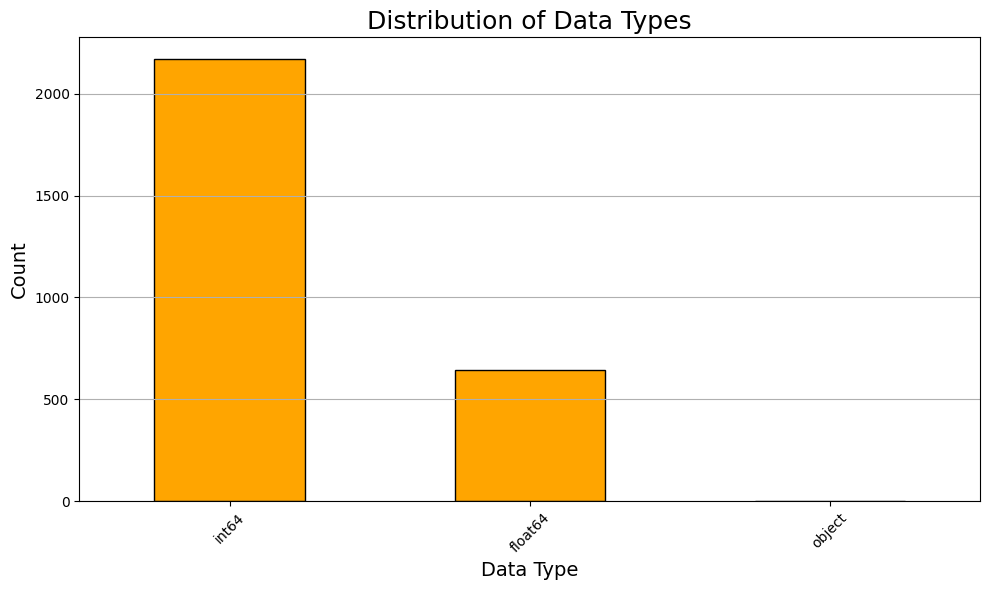

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_data_type_distribution(df: pd.DataFrame) -> None:
    """
    Plots a bar graph showing the distribution of different data types in the DataFrame.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    """
    # Count the occurrences of each data type
    data_type_counts = df.dtypes.value_counts()

    # Plotting the bar graph
    plt.figure(figsize=(10, 6))
    data_type_counts.plot(kind='bar', color='orange', edgecolor='black')
    plt.title('Distribution of Data Types', fontsize=18)
    plt.xlabel('Data Type', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45)  # Rotate x labels for better readability
    plt.grid(axis='y')  # Add grid lines for better readability
    plt.tight_layout()  # Adjust layout for better fit
    plt.show()

# Example usage
# df = pd.read_csv('your_data.csv')  # Load your dataset
plot_data_type_distribution(df)


In [47]:
# Get only object (string) columns
object_cols = df.select_dtypes(include='object')
print("Object Columns:")
print(object_cols.columns)

Object Columns:
Index(['FILEDATE', 'GQTYPE2'], dtype='object')


In [49]:
df['GQTYPE2'].unique()

array(['O', None, 'C'], dtype=object)

In [50]:
# Calculate the percentage of zero values for each column
zero_percentage = (df == 0).mean()

# Define a threshold for sparsity, e.g., 80% zero values
sparsity_threshold = 0.8

# Identify sparse columns based on zero values
sparse_zero_columns = zero_percentage[zero_percentage > sparsity_threshold].index.tolist()

# Combine all sparse columns
sparse_columns = list(set(sparse_zero_columns + single_unique_columns))

print("Sparse Columns:", sparse_columns)

Sparse Columns: ['TXYRDRPAL', 'APPDRGMON2', 'DEPNDHER', 'SMHSUI2', 'TXPDSVNGAL', 'METHPDAPYU', 'SIMHMEN2', 'SIMHEAT2', 'TXYRMHCIL', 'PCPYR', 'MJONLYYR', 'UADSCHL', 'TRQOTANYR2', 'EDFAM18', 'ABUSEHER', 'HERMON', 'AMMEPDAPYU', 'AMDEHPO', 'ILLEMMON', 'TXYRSLFIL', 'MHRNOND2', 'STMOTHPYMU2', 'FDOCOTPP', 'GLUE2', 'SEDOTANYR2', 'TRQNMYR', 'TXYSPALNIL', 'MHRCFID2', 'UADBAR', 'TXLTYMETH2', 'AMPHETAPYU', 'MHRCMIT2', 'TXPDSVNGIL', 'SHSWEAT', 'SRCFRTRQNM', 'ATXMDEYR', 'SIMHFML2', 'SRCTRQNM2', 'HALLUCMON', 'NDSSANSP', 'MHPDREH2', 'SMHBRK2', 'GQTYPE2', 'SALVIAFLAG', 'ANURSMDE', 'UDPYILAAL', 'DEPNDPYMTH', 'ARXMDEYR', 'SHSWFITE', 'TXYRPRIIL', 'SRCSEDNM2', 'CRKMON', 'KRATREC', 'YHBCHMDE', 'PCPMON', 'GAS2', 'BUPRPDAPYU', 'CADRKINHL2', 'ABUSEPYPSY', 'UDPYMTH', 'TXYRALC', 'TXPDPUBLIL', 'PIPFLAG', 'SRCFRSEDNM', 'ECSTMOYR', 'SMHFEA2', 'TXPAYMCAD2', 'RCVYMHPRB', 'HYDMPDPYMU', 'LORAPDAPYU', 'MTDNPDAPYU', 'SIMHOTP2', 'SRCCLFRTRQ', 'OXYMPDPYMU', 'TXLTYHERN2', 'SIMHANG2', 'PNROTHPYMU2', 'TRQOTHPYMU2', 'SHSWFEA',

In [54]:
# Identify columns with only one unique non-NaN value
single_unique_columns = [col for col in df.columns if df[col].nunique(dropna=True) == 1]

print("Columns with One Unique Non-NaN Value:", single_unique_columns)

Columns with One Unique Non-NaN Value: []


In [59]:
# Identify columns with exactly two unique non-NaN values
two_unique_columns = [col for col in df.columns if df[col].nunique(dropna=True) == 2]

print("Number of Columns with two Unique Non-NaN Value:", len(two_unique_columns))

# Print the columns and their unique values
for col in two_unique_columns:
    unique_values = df[col].dropna().unique()
    print(f"Column: {col}, Unique Values: {unique_values}")






Number of Columns with two Unique Non-NaN Value: 780
Column: CIGEVER, Unique Values: [1 2]
Column: ALFQFLG, Unique Values: [98  1]
Column: ALDYSFG, Unique Values: [98  1]
Column: MJFQFLG, Unique Values: [98  1]
Column: CCFQFLG, Unique Values: [98  1]
Column: CRTOTFG, Unique Values: [98  2]
Column: CRFQFLG, Unique Values: [98  1]
Column: HRFQFLG, Unique Values: [98  1]
Column: HALTOTFG, Unique Values: [98  2]
Column: HALFQFLG, Unique Values: [98  1]
Column: INHFQFLG, Unique Values: [98  1]
Column: MEFQFLG, Unique Values: [98  1]
Column: PNRNORXFG, Unique Values: [98  1]
Column: TRQNORXFG, Unique Values: [98  1]
Column: STMNORXFG, Unique Values: [98  1]
Column: SEDNORXFG, Unique Values: [98  1]
Column: IRPIPLF, Unique Values: [9 1]
Column: IIPIPLF, Unique Values: [1 3]
Column: IICRKRC, Unique Values: [1 3]
Column: IIPCPRC, Unique Values: [1 3]
Column: IROXCNANYYR, Unique Values: [9 1]
Column: IROXCNNMYR, Unique Values: [9 1]
Column: CIGFLAG, Unique Values: [1 0]
Column: CIGYR, Unique Val

In [62]:
# Define a dictionary for replacements based on the code conventions
code_replacements = {
    91: 'Never Used',
    991: 'Never Used',
    9991: 'Never Used',
    93: 'Used Not in Period',
    993: 'Used Not in Period',
    9993: 'Used Not in Period',
    94: np.nan,  # Don't Know
    994: np.nan,
    9994: np.nan,
    97: np.nan,  # Refused
    997: np.nan,
    9997: np.nan,
    98: np.nan,  # Blank
    998: np.nan,
    9998: np.nan,
    99: np.nan,  # Legitimate Skip
    999: np.nan,
    9999: np.nan
}

# Apply the replacements to the DataFrame
df.replace(code_replacements, inplace=True)

# Verify changes
print(df.head())

   QUESTID2    FILEDATE  CIGEVER  CIGOFRSM  CIGWILYR      CIGTRY      CIGYFU  \
0  25095143  02/15/2018        1       NaN       NaN          16        2014   
1  13005143  02/15/2018        1       NaN       NaN          15         NaN   
2  67415143  02/15/2018        2       NaN       NaN  Never Used  Never Used   
3  70925143  02/15/2018        2       3.0       4.0  Never Used  Never Used   
4  75235143  02/15/2018        1       NaN       NaN          17         NaN   

       CIGMFU      CIGREC            CIG30USE  ... CASUPROB2 RCVYSUBPRB  \
0           1           2  Used Not in Period  ...       NaN        NaN   
1         NaN           3  Used Not in Period  ...       NaN        NaN   
2  Never Used  Never Used          Never Used  ...       NaN        NaN   
3  Never Used  Never Used          Never Used  ...       NaN        NaN   
4         NaN           1                  22  ...       NaN        NaN   

  CAMHPROB2 RCVYMHPRB ALMEDYR2 OPMEDYR2 ALOPMEDYR KRATFLG KRATYR KRA

In [46]:
df.describe()

QUESTID2        CIGEVER       CIGOFRSM       CIGWILYR  \
count  2.827680e+05  282768.000000  282768.000000  282768.000000   
mean   5.437871e+07       1.518206      78.760769      78.772658   
std    2.555784e+07       0.499669      38.939667      38.920773   
min    1.000061e+07       1.000000       1.000000       1.000000   
25%    3.213524e+07       1.000000      99.000000      99.000000   
50%    5.410674e+07       2.000000      99.000000      99.000000   
75%    7.609047e+07       2.000000      99.000000      99.000000   
max    1.000000e+08       2.000000      99.000000      99.000000   

              CIGTRY         CIGYFU         CIGMFU         CIGREC  \
count  282768.000000  282768.000000  282768.000000  282768.000000   
mean      527.115519    9825.702113      92.954227      48.475361   
std       486.975797    1148.802267      12.877991      44.129283   
min         1.000000    2013.000000       1.000000       1.000000   
25%        16.000000    9991.000000      91.000000       3.000000   
50%       991.000000    9991.000000      91.000000      91.000000   
75%       991.000000    9999.000000      99.000000      91.000000   
max       997.000000    9999.000000      99.000000      91.000000   

            CIG30USE        CG30EST  ...     CASUPROB2    RCVYSUBPRB  \
count  282768.000000  282768.000000  ...  42383.000000  42361.000000   
mean       79.002557      92.927230  ...      0.111153      0.081278   
std        27.699494       4.341968  ...      0.314325      0.273264   
min         1.000000       1.000000  ...      0.000000      0.000000   
25%        91.000000      91.000000  ...      0.000000      0.000000   
50%        91.000000      91.000000  ...      0.000000      0.000000   
75%        93.000000      93.000000  ...      0.000000      0.000000   
max        98.000000      99.000000  ...      1.000000      1.000000   

          CAMHPROB2     RCVYMHPRB      ALMEDYR2      OPMEDYR2     ALOPMEDYR  \
count  42394.000000  42316.000000  56136.000000  56136.000000  56136.000000   
mean       0.243832      0.164760      0.000980      0.002619      0.003474   
std        0.429397      0.370969      0.031286      0.051106      0.058836   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            KRATFLG        KRATYR       KRATMON  
count  56136.000000  56136.000000  56136.000000  
mean       0.016888      0.008604      0.003474  
std        0.128851      0.092359      0.058836  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000  
max        1.000000      1.000000      1.000000  

[8 rows x 2812 columns]

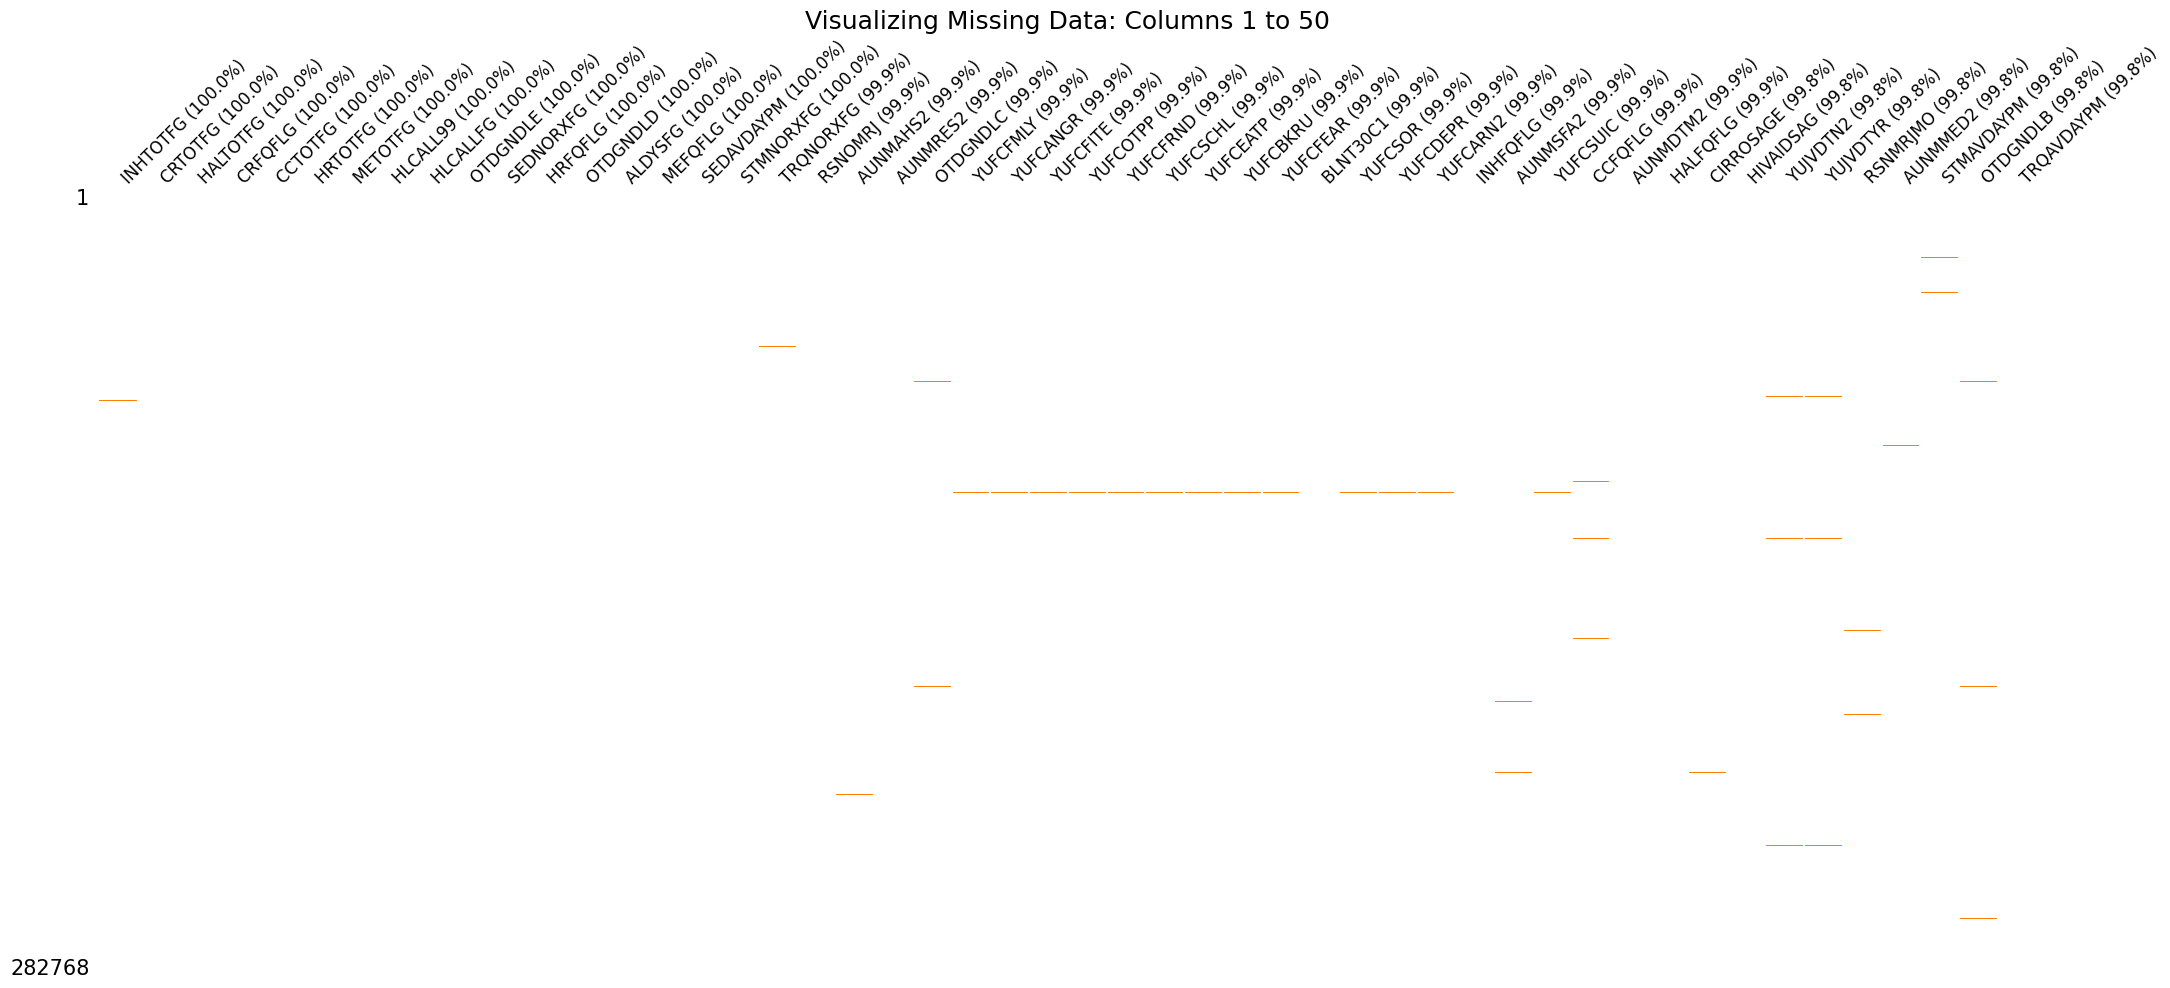

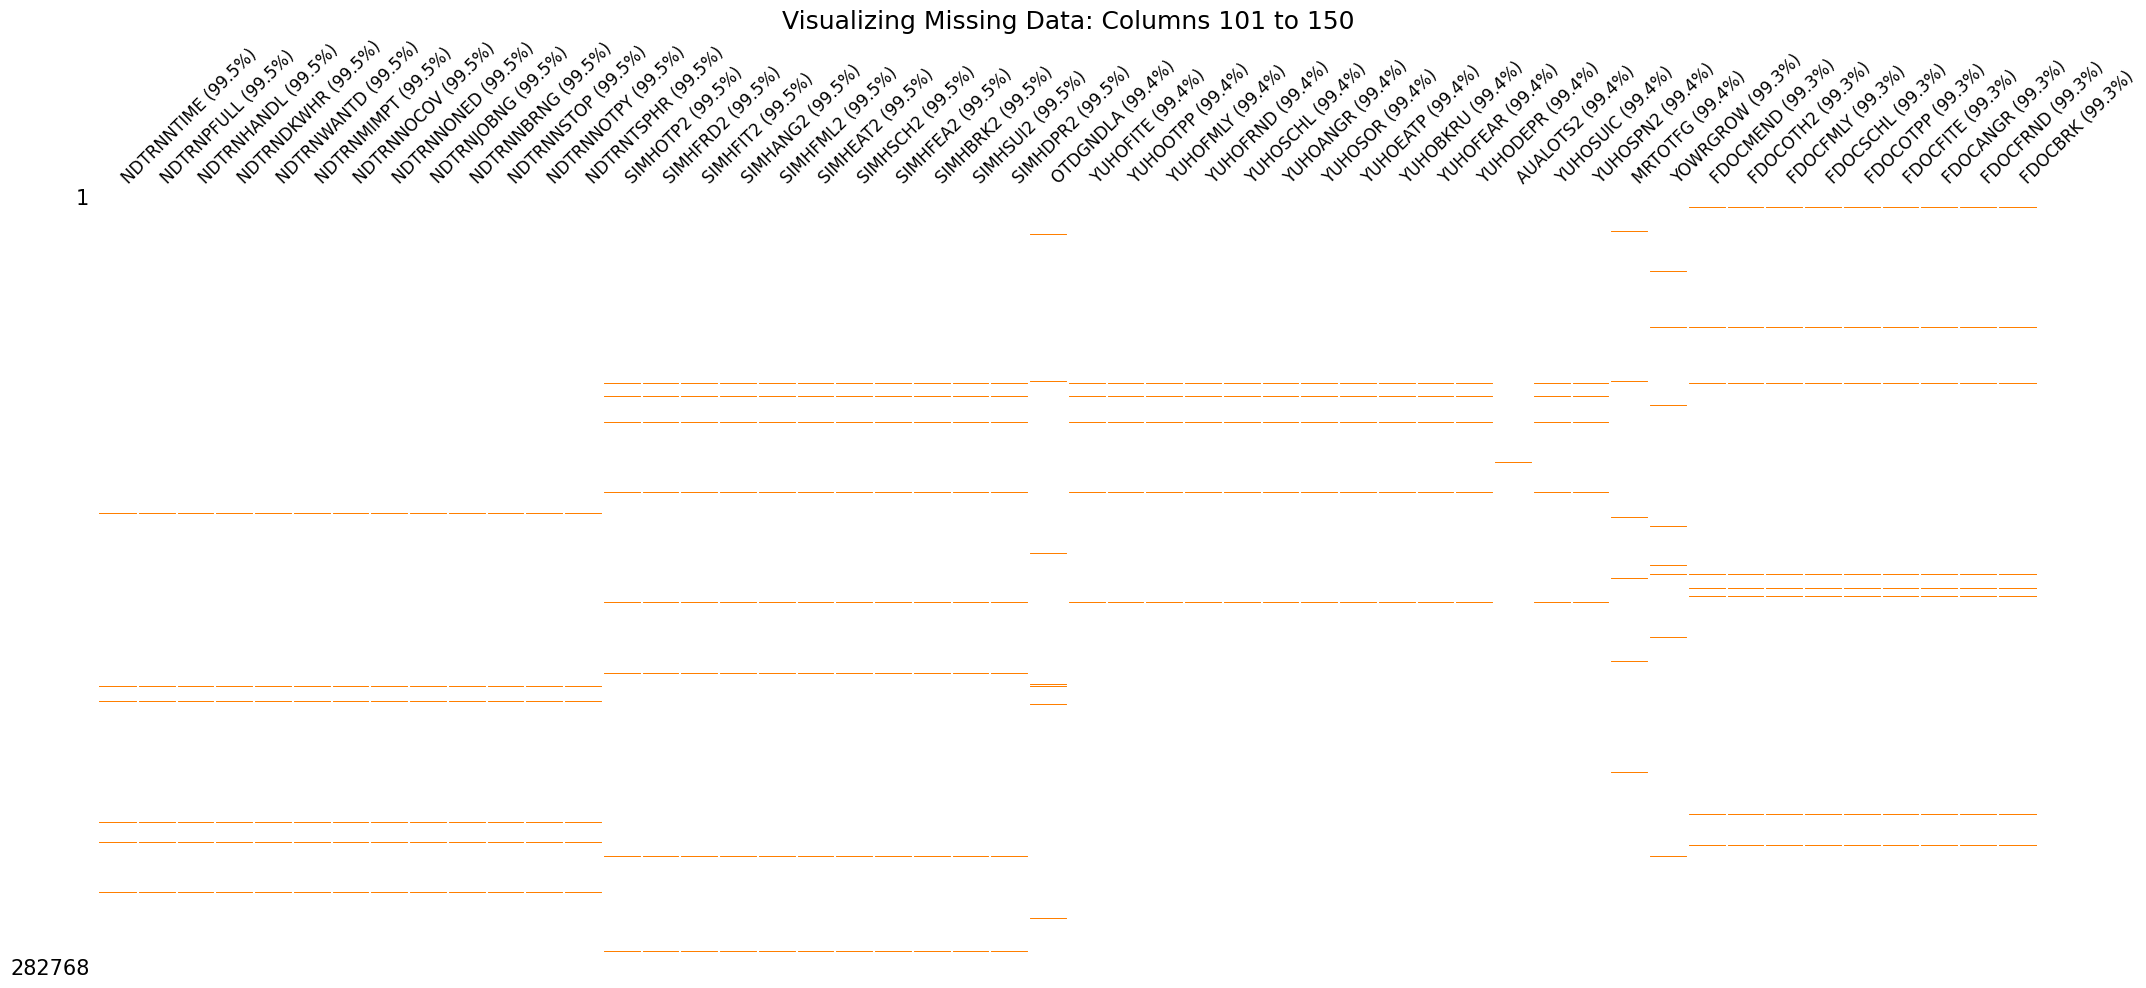

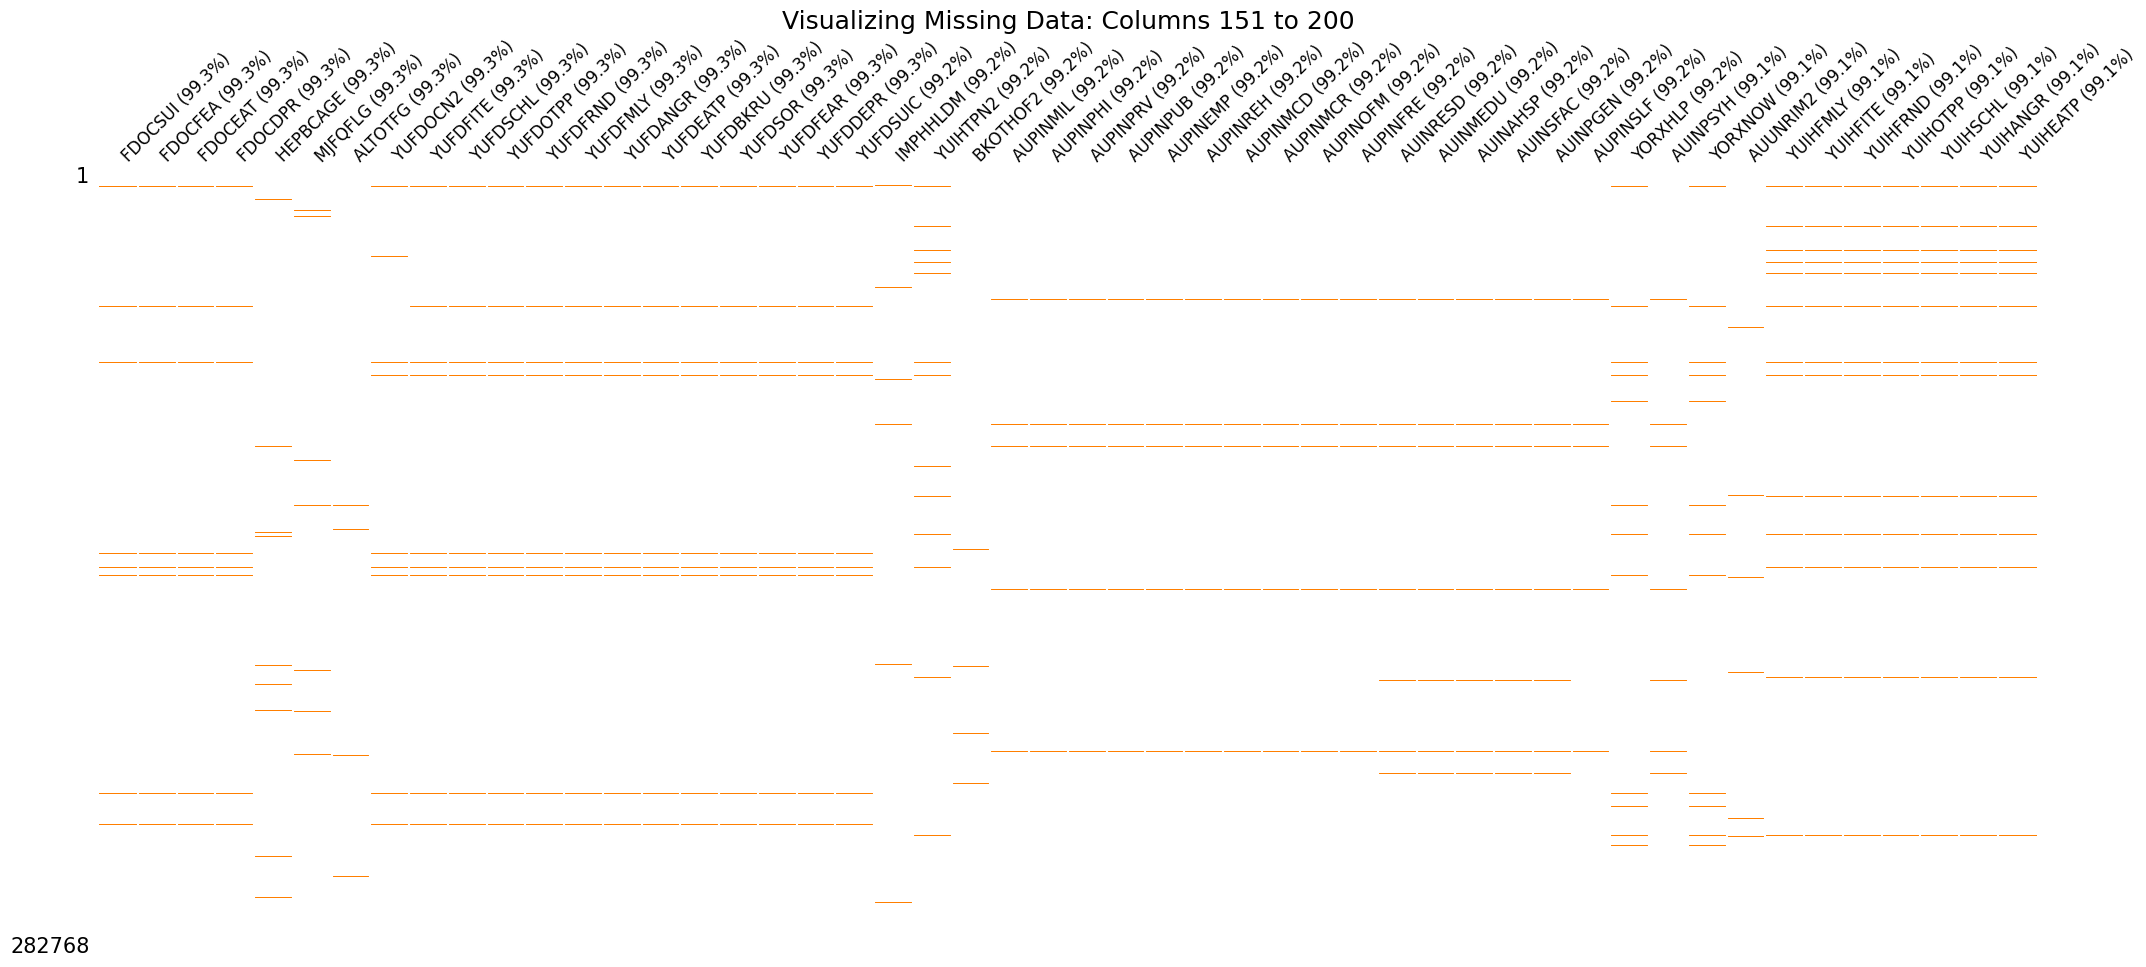

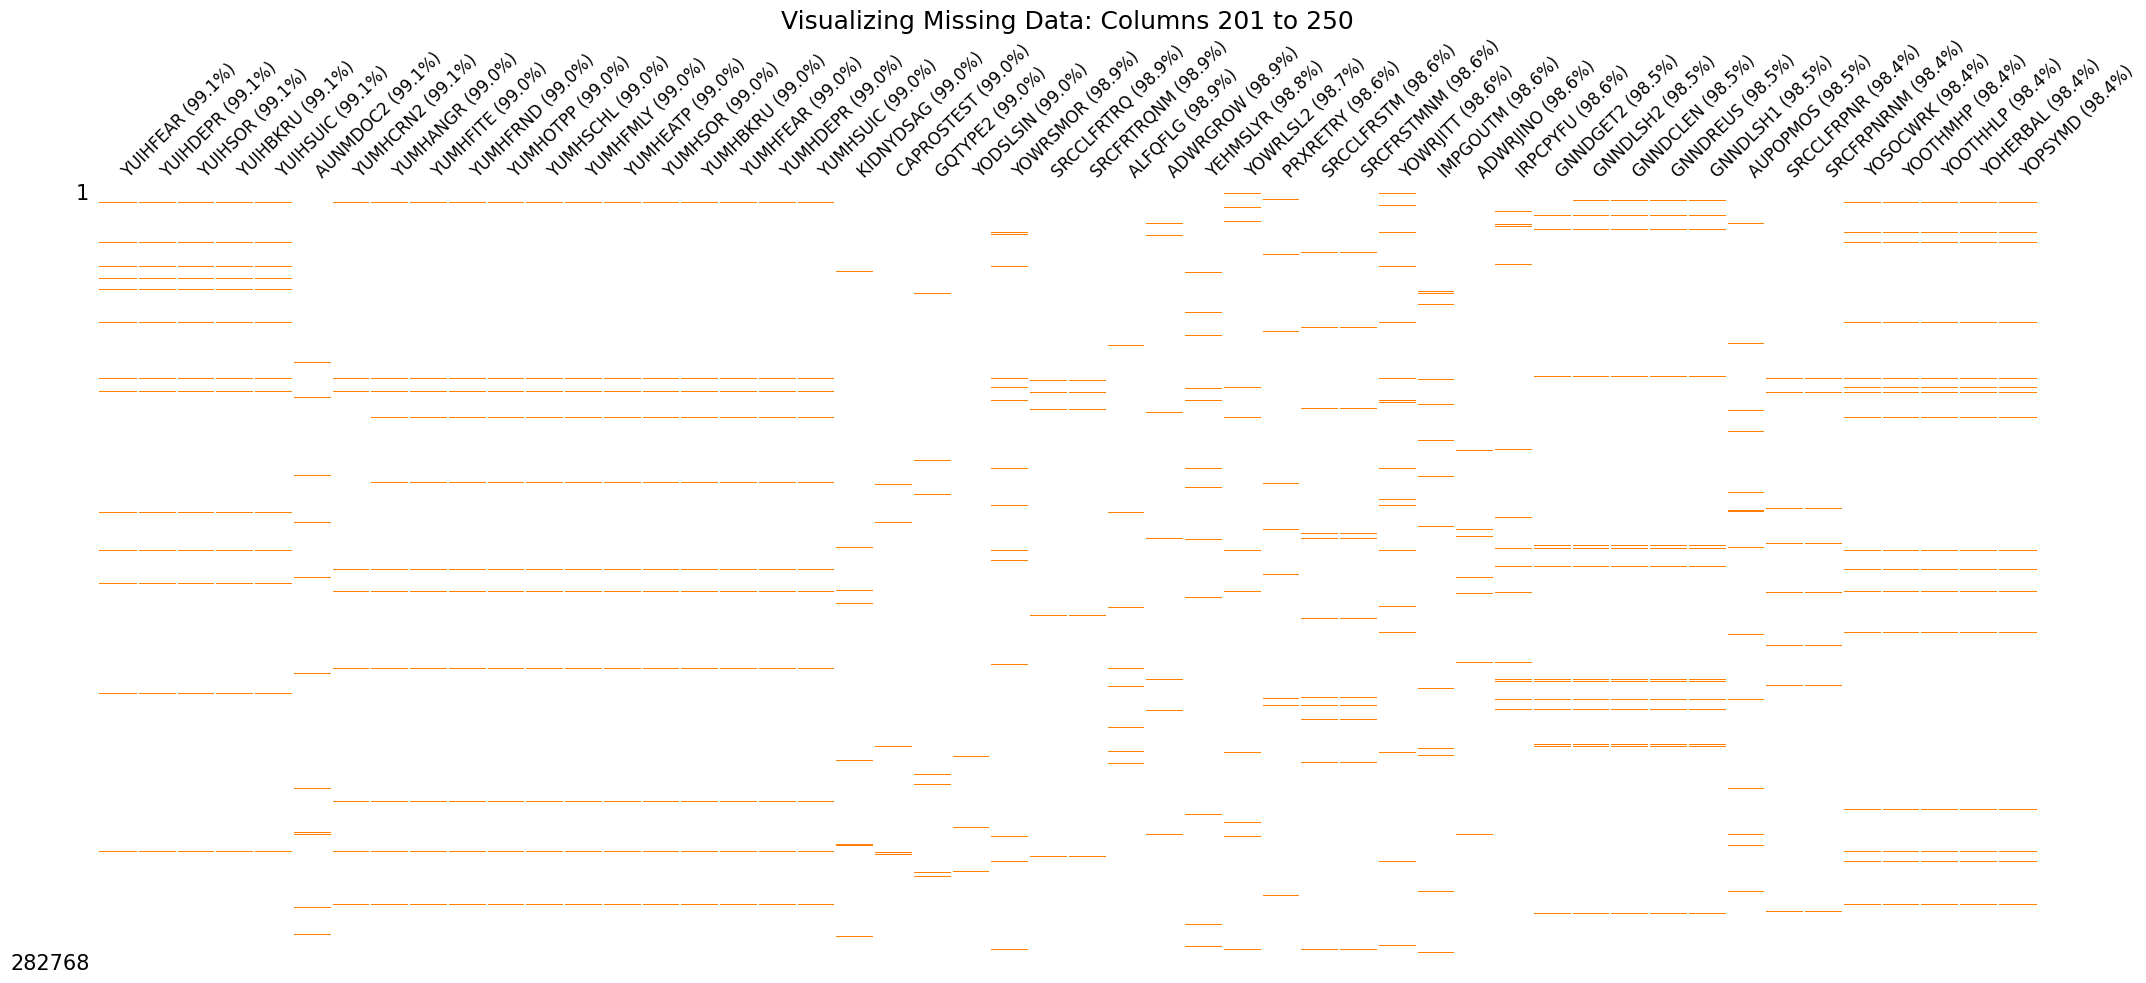

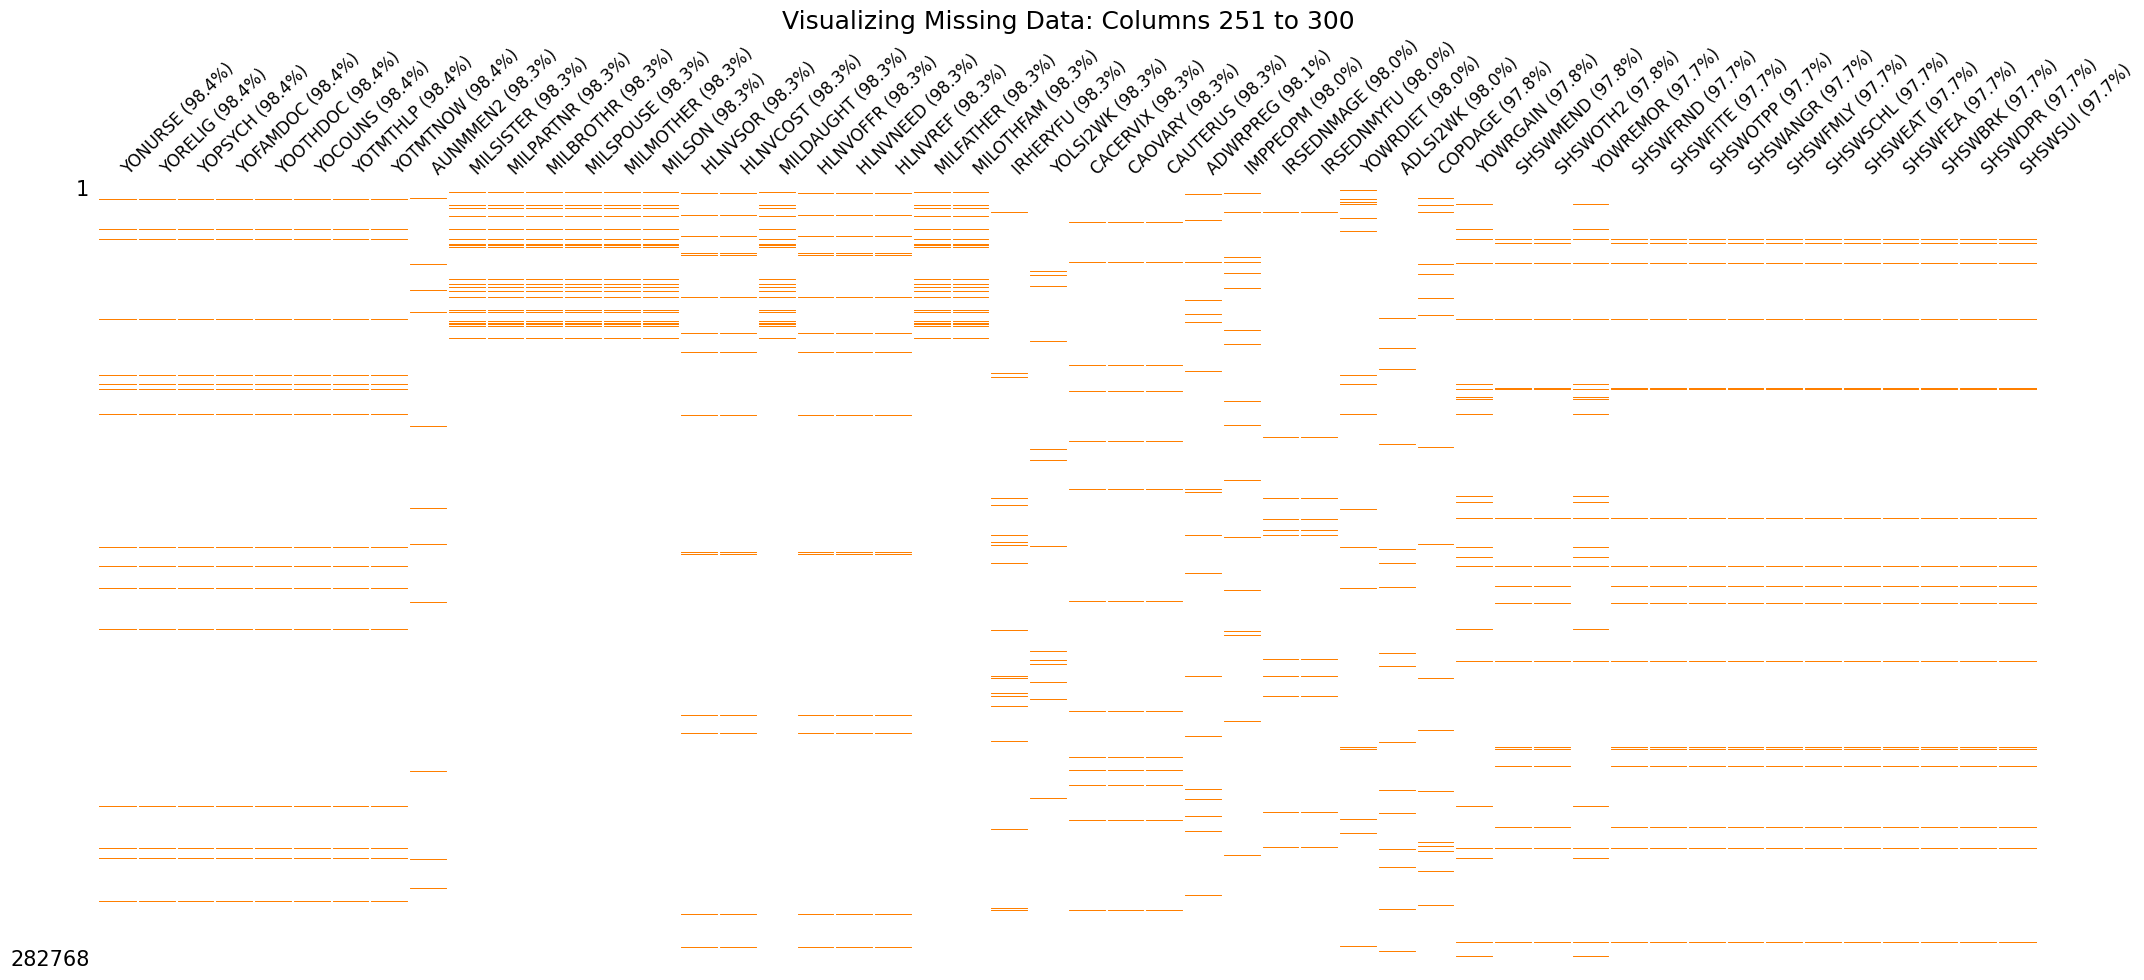

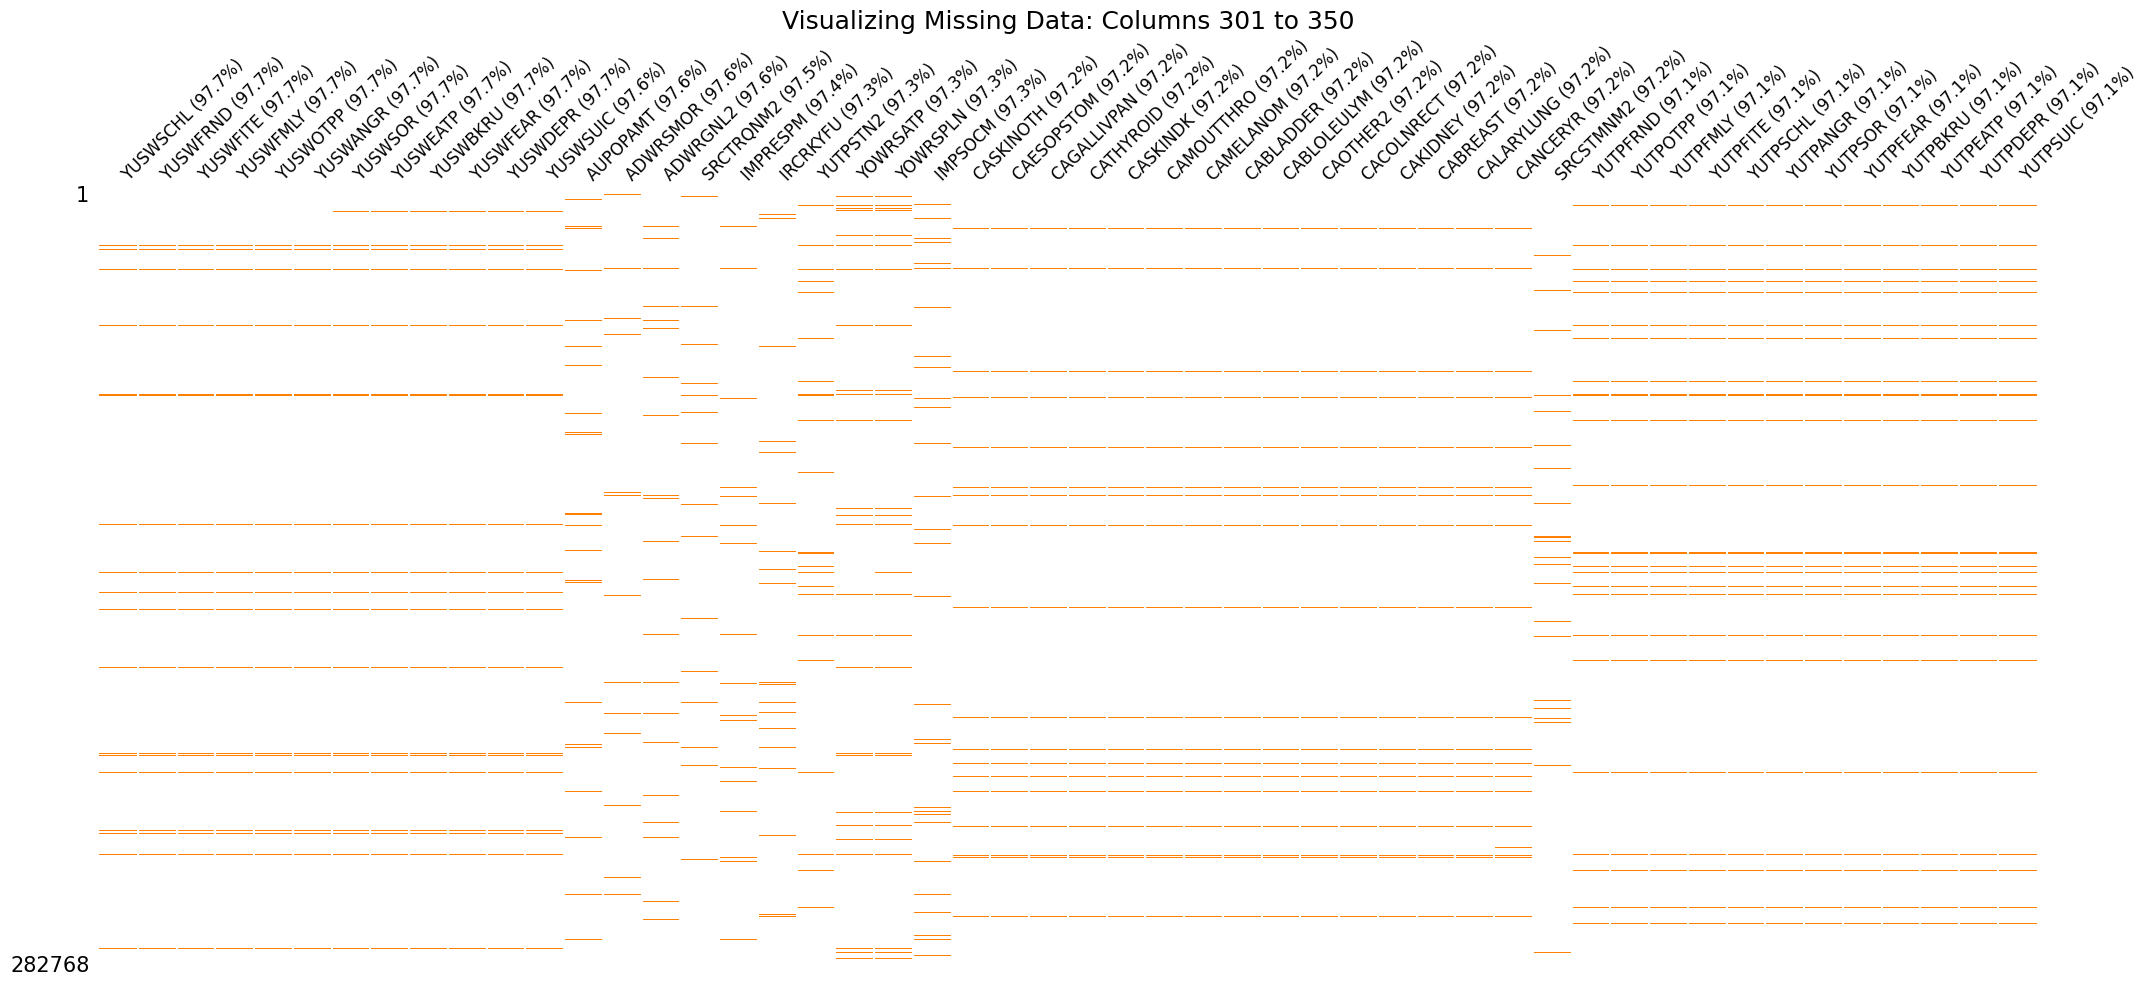

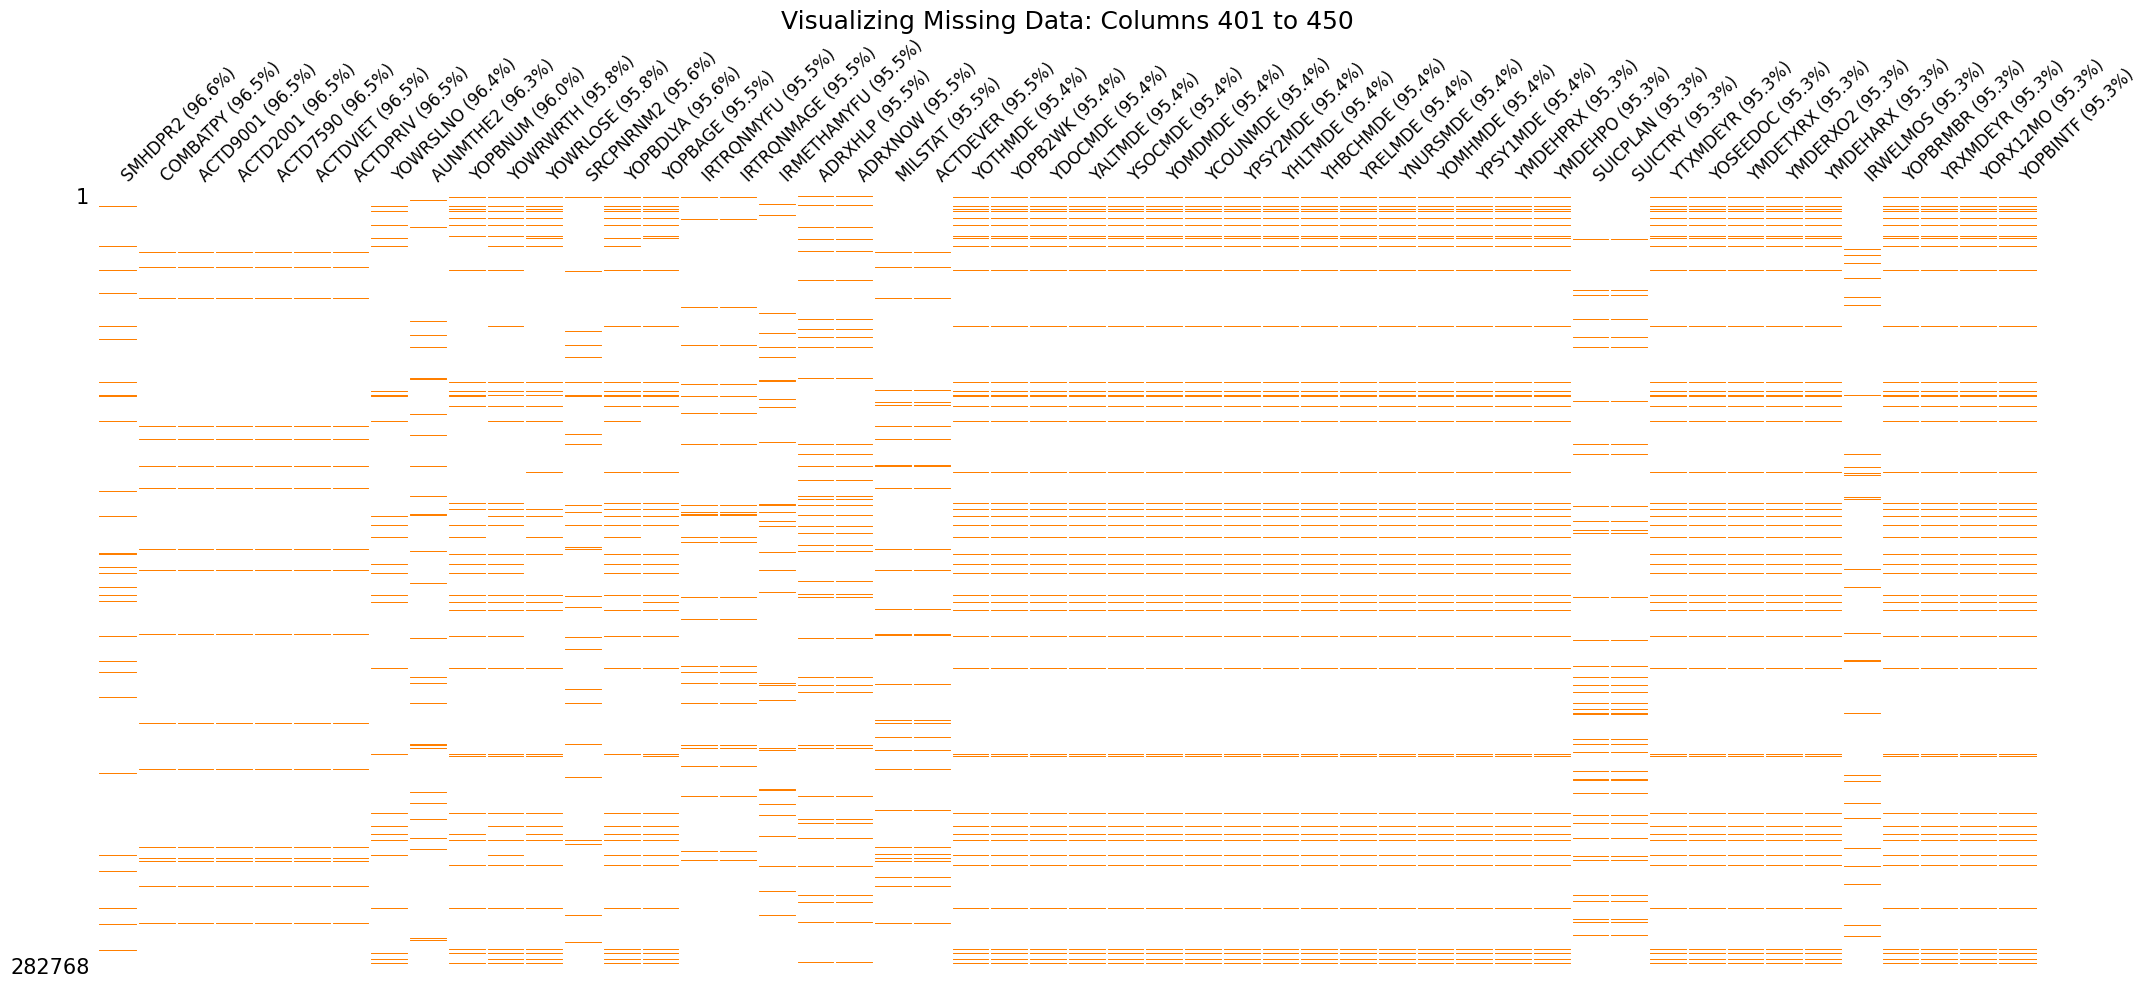

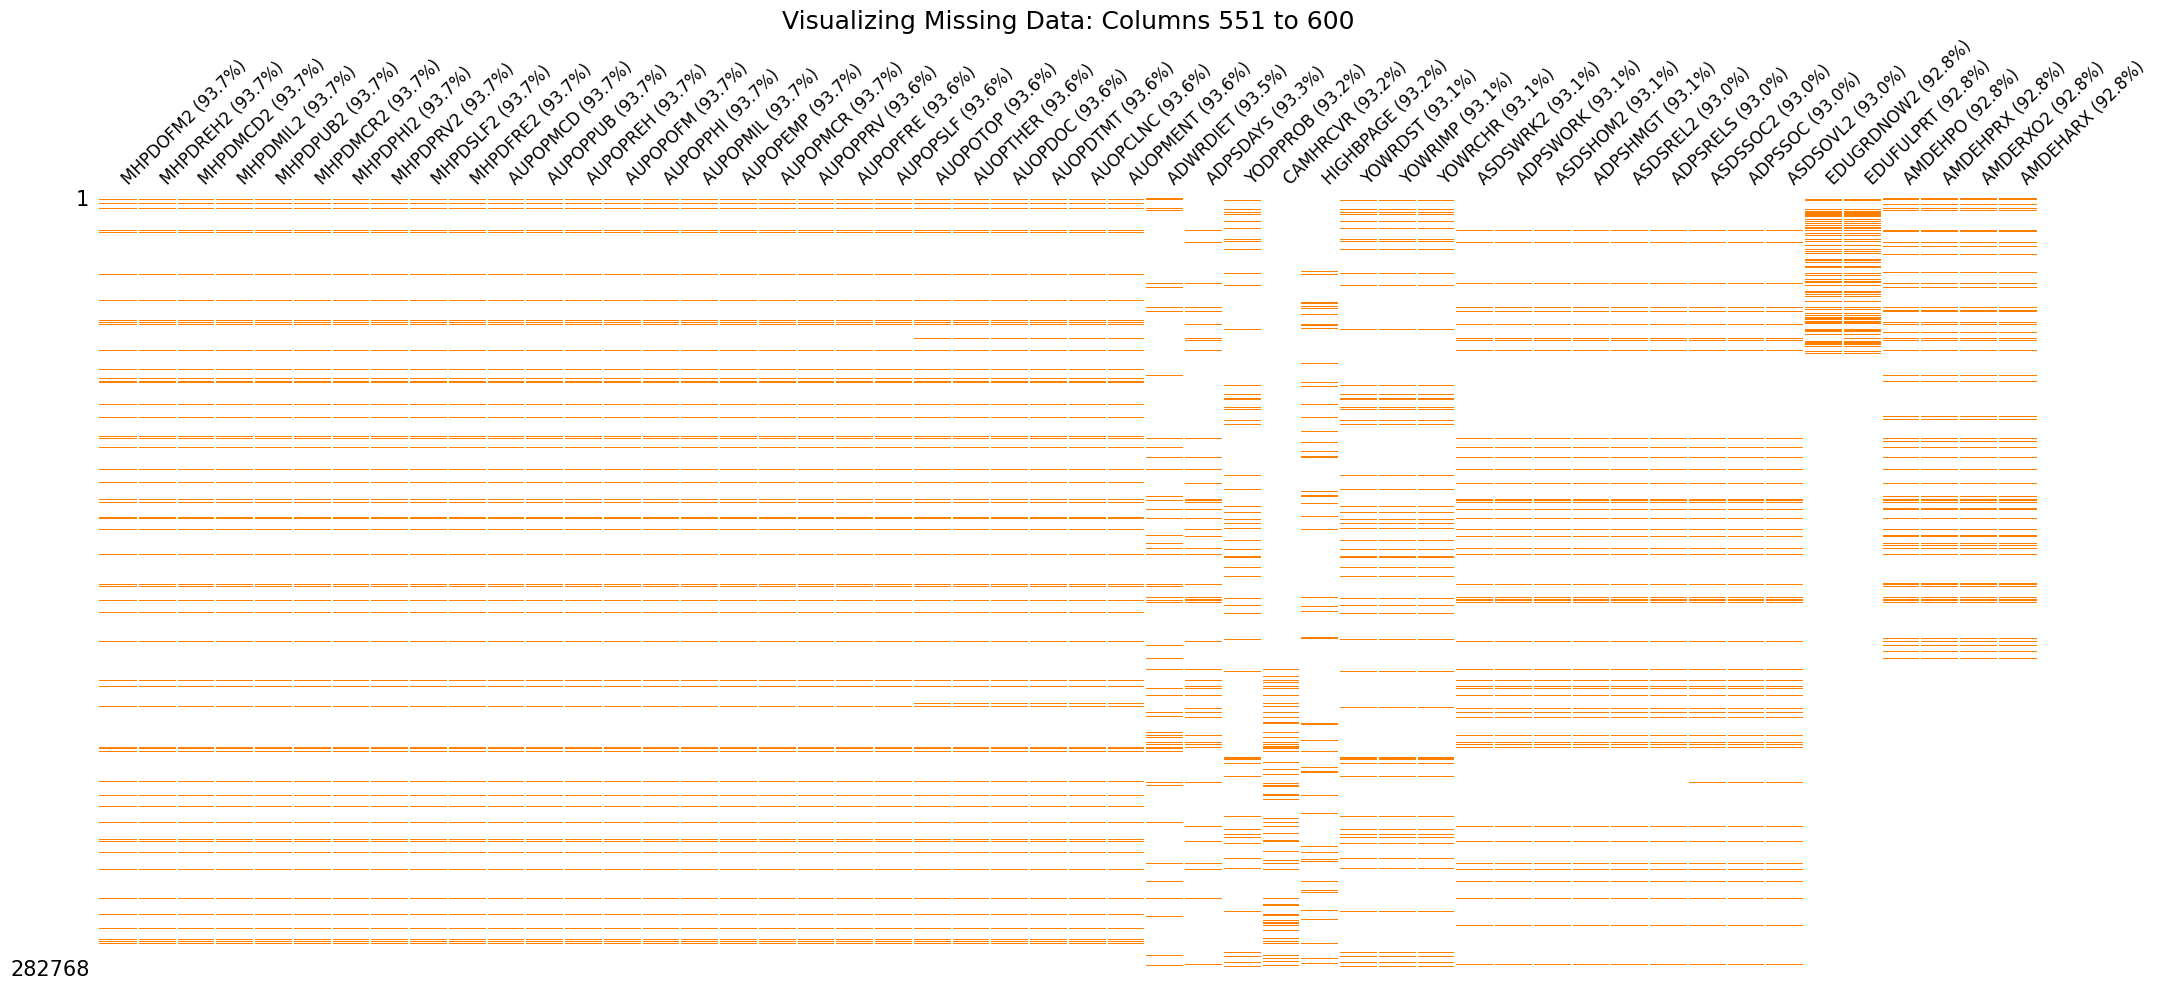

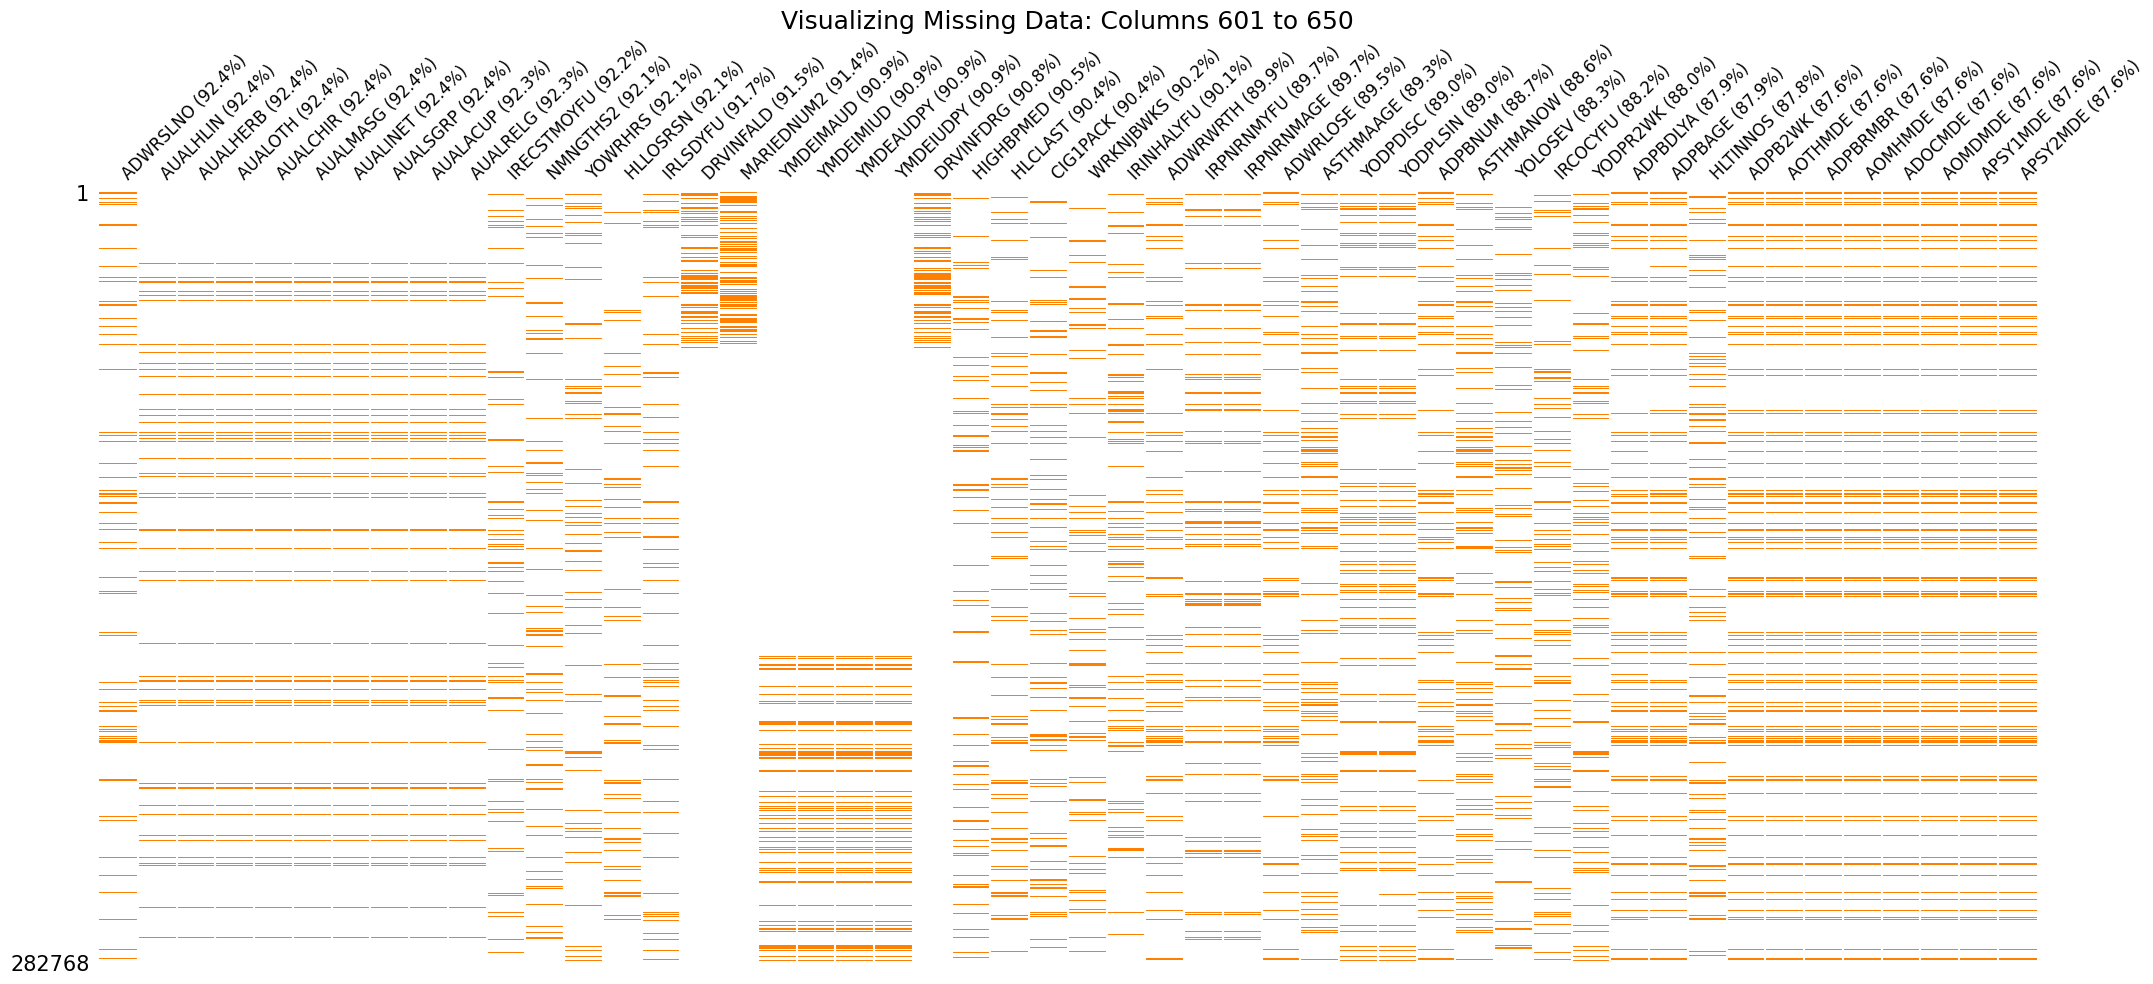

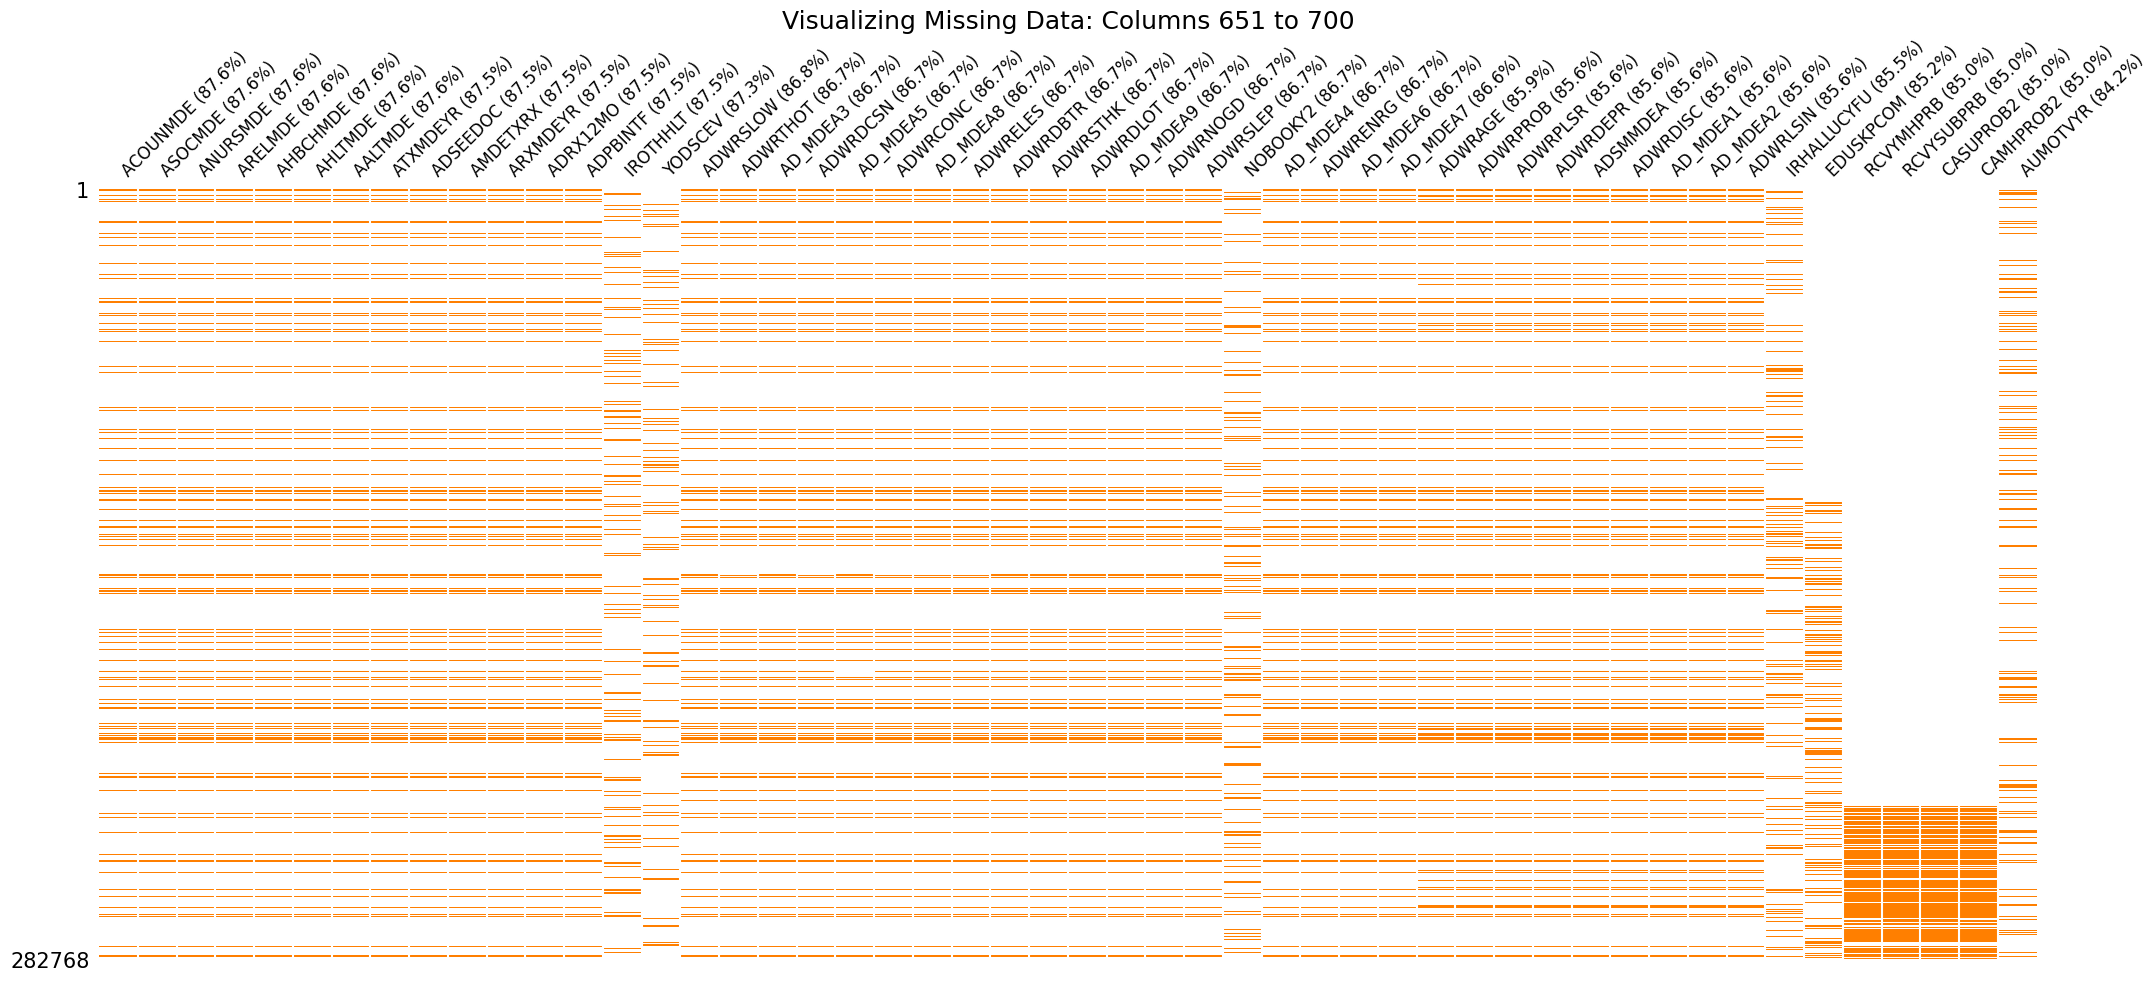

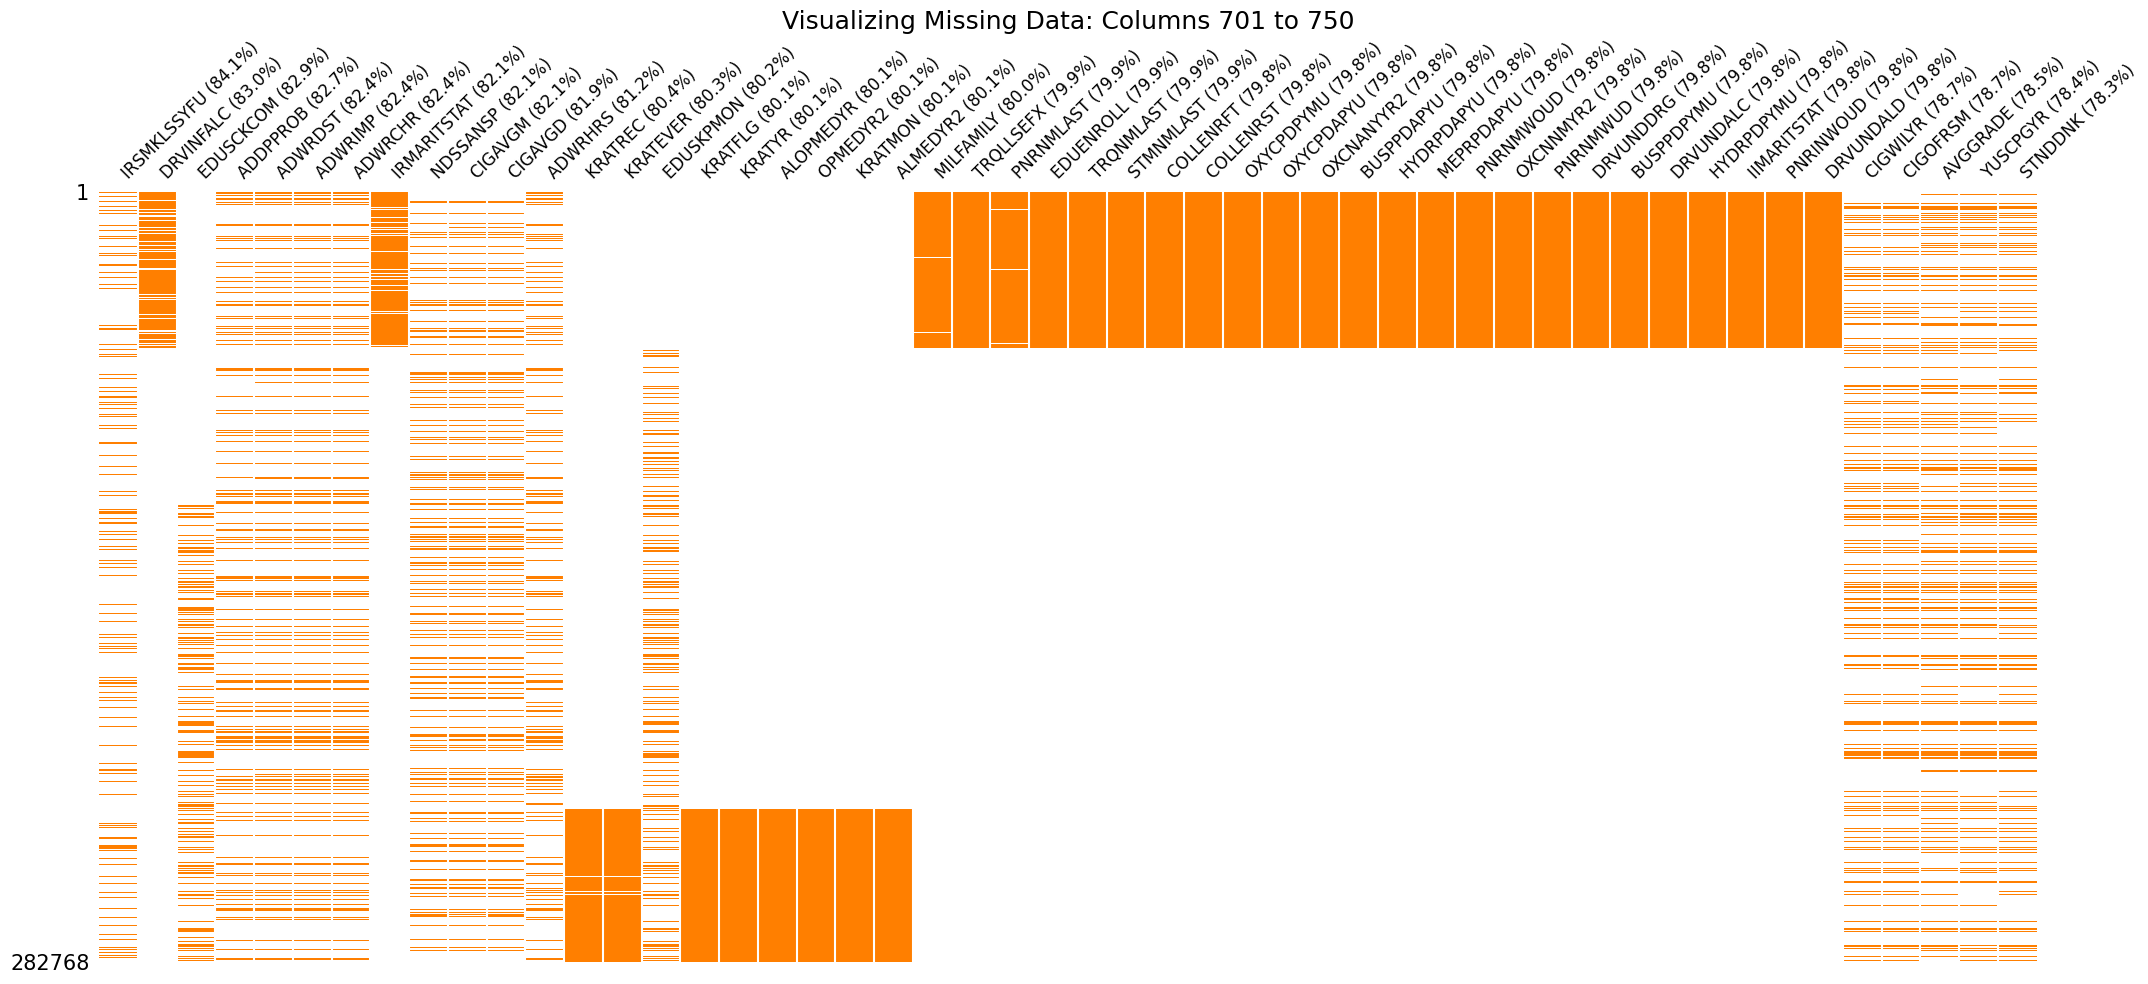

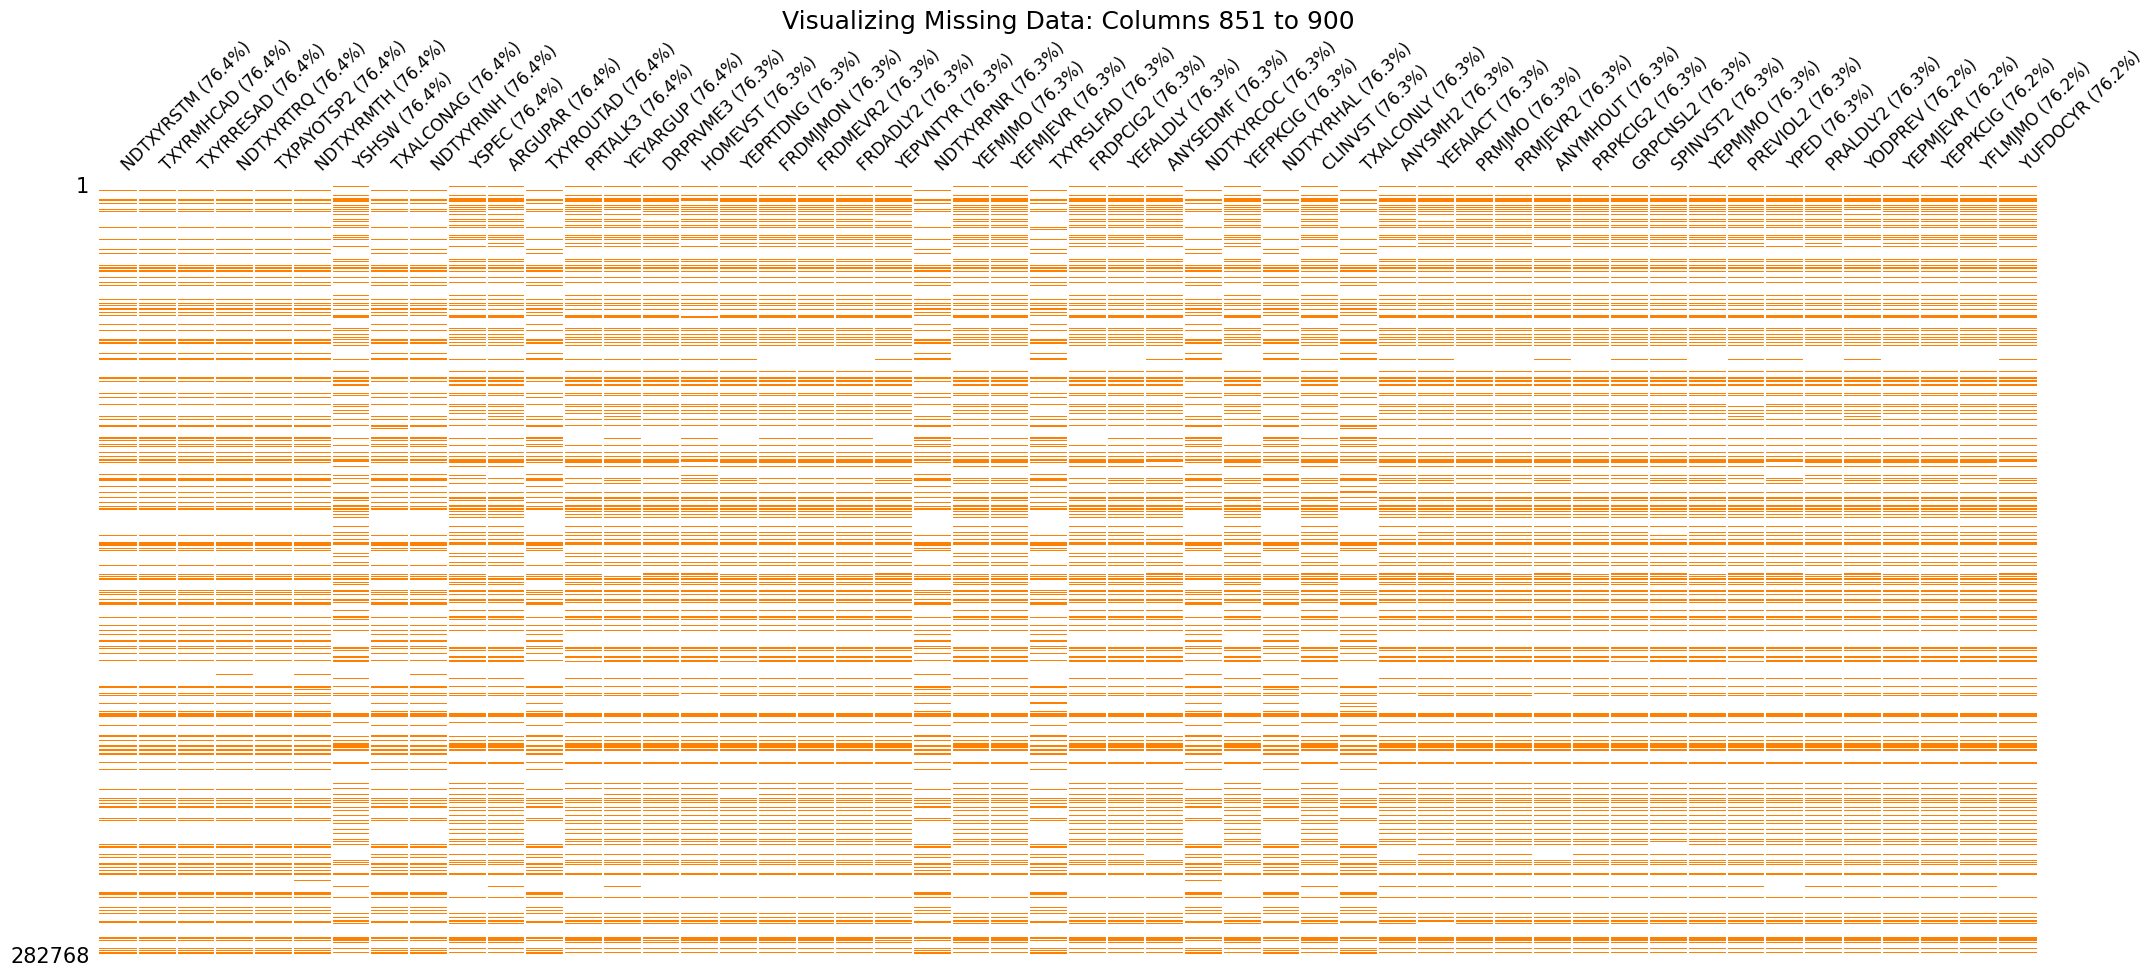

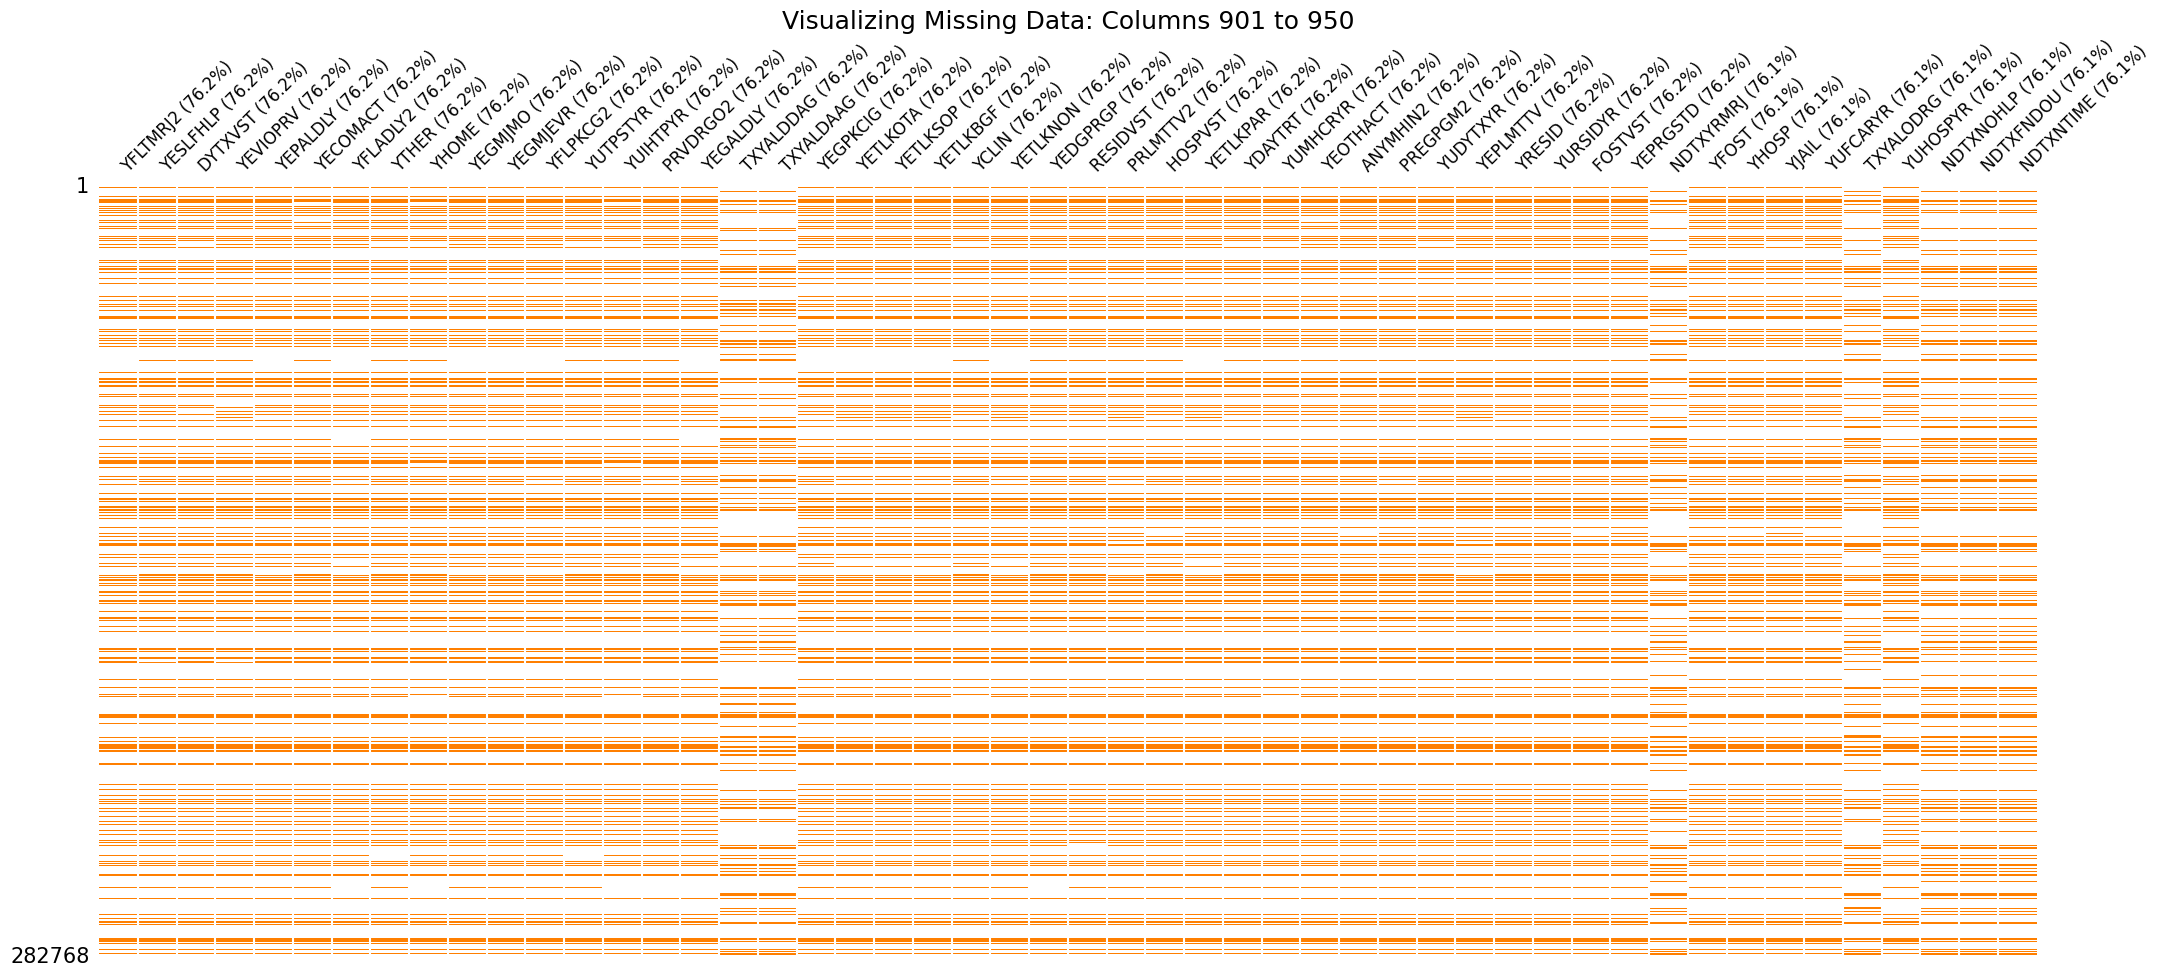

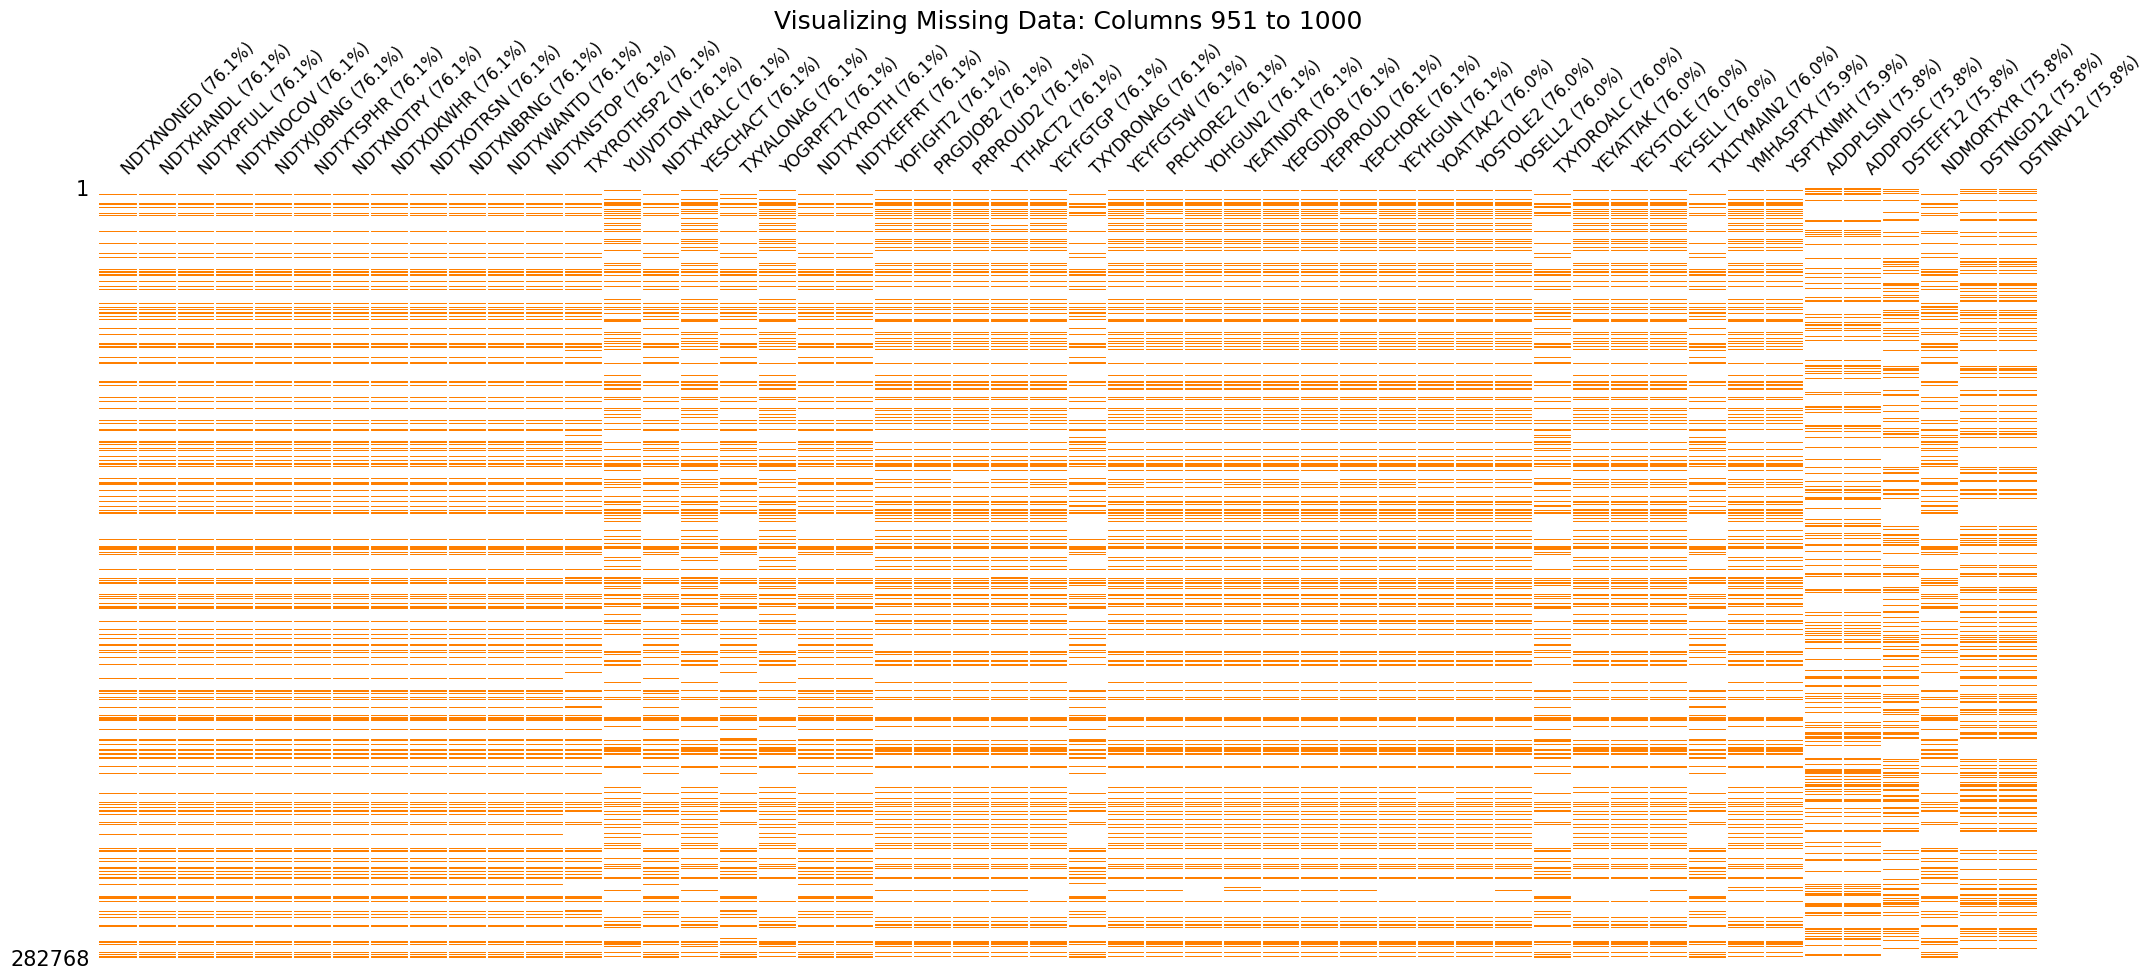

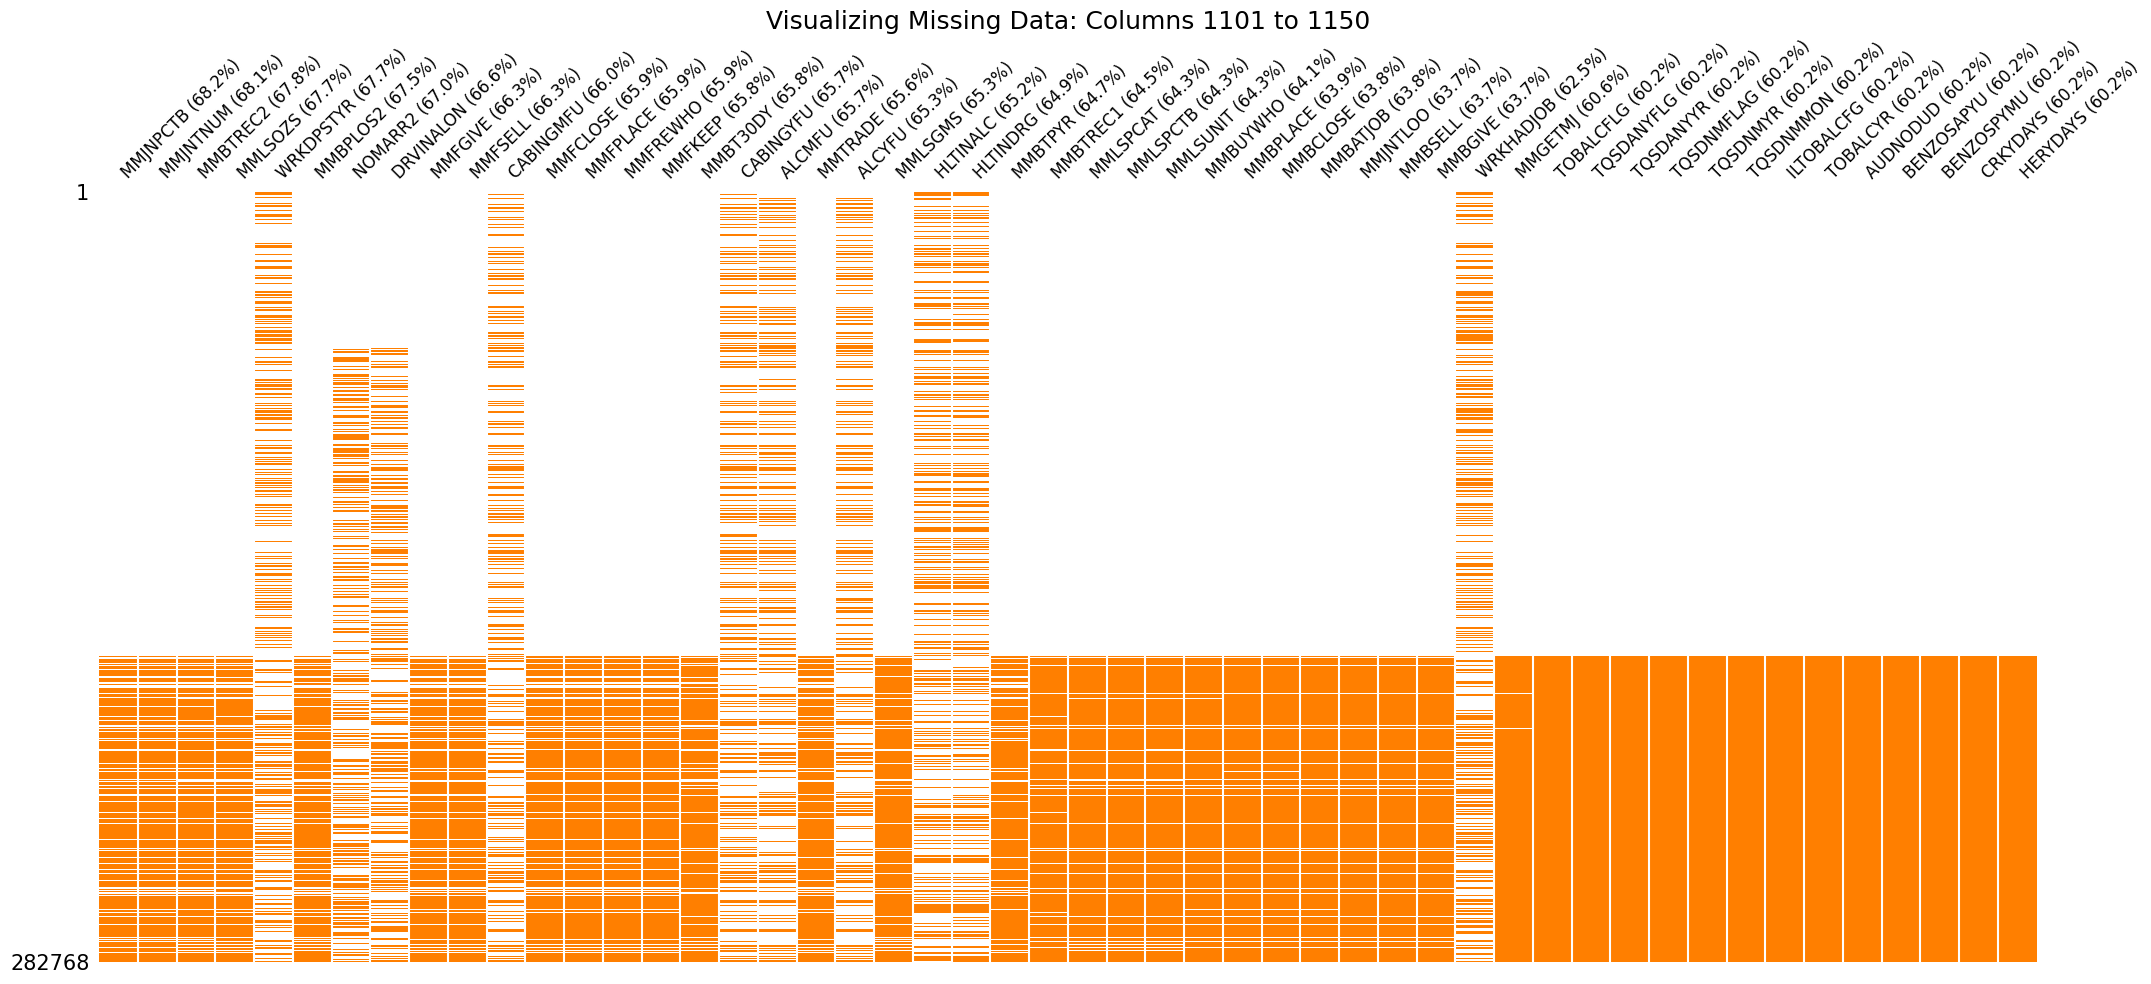

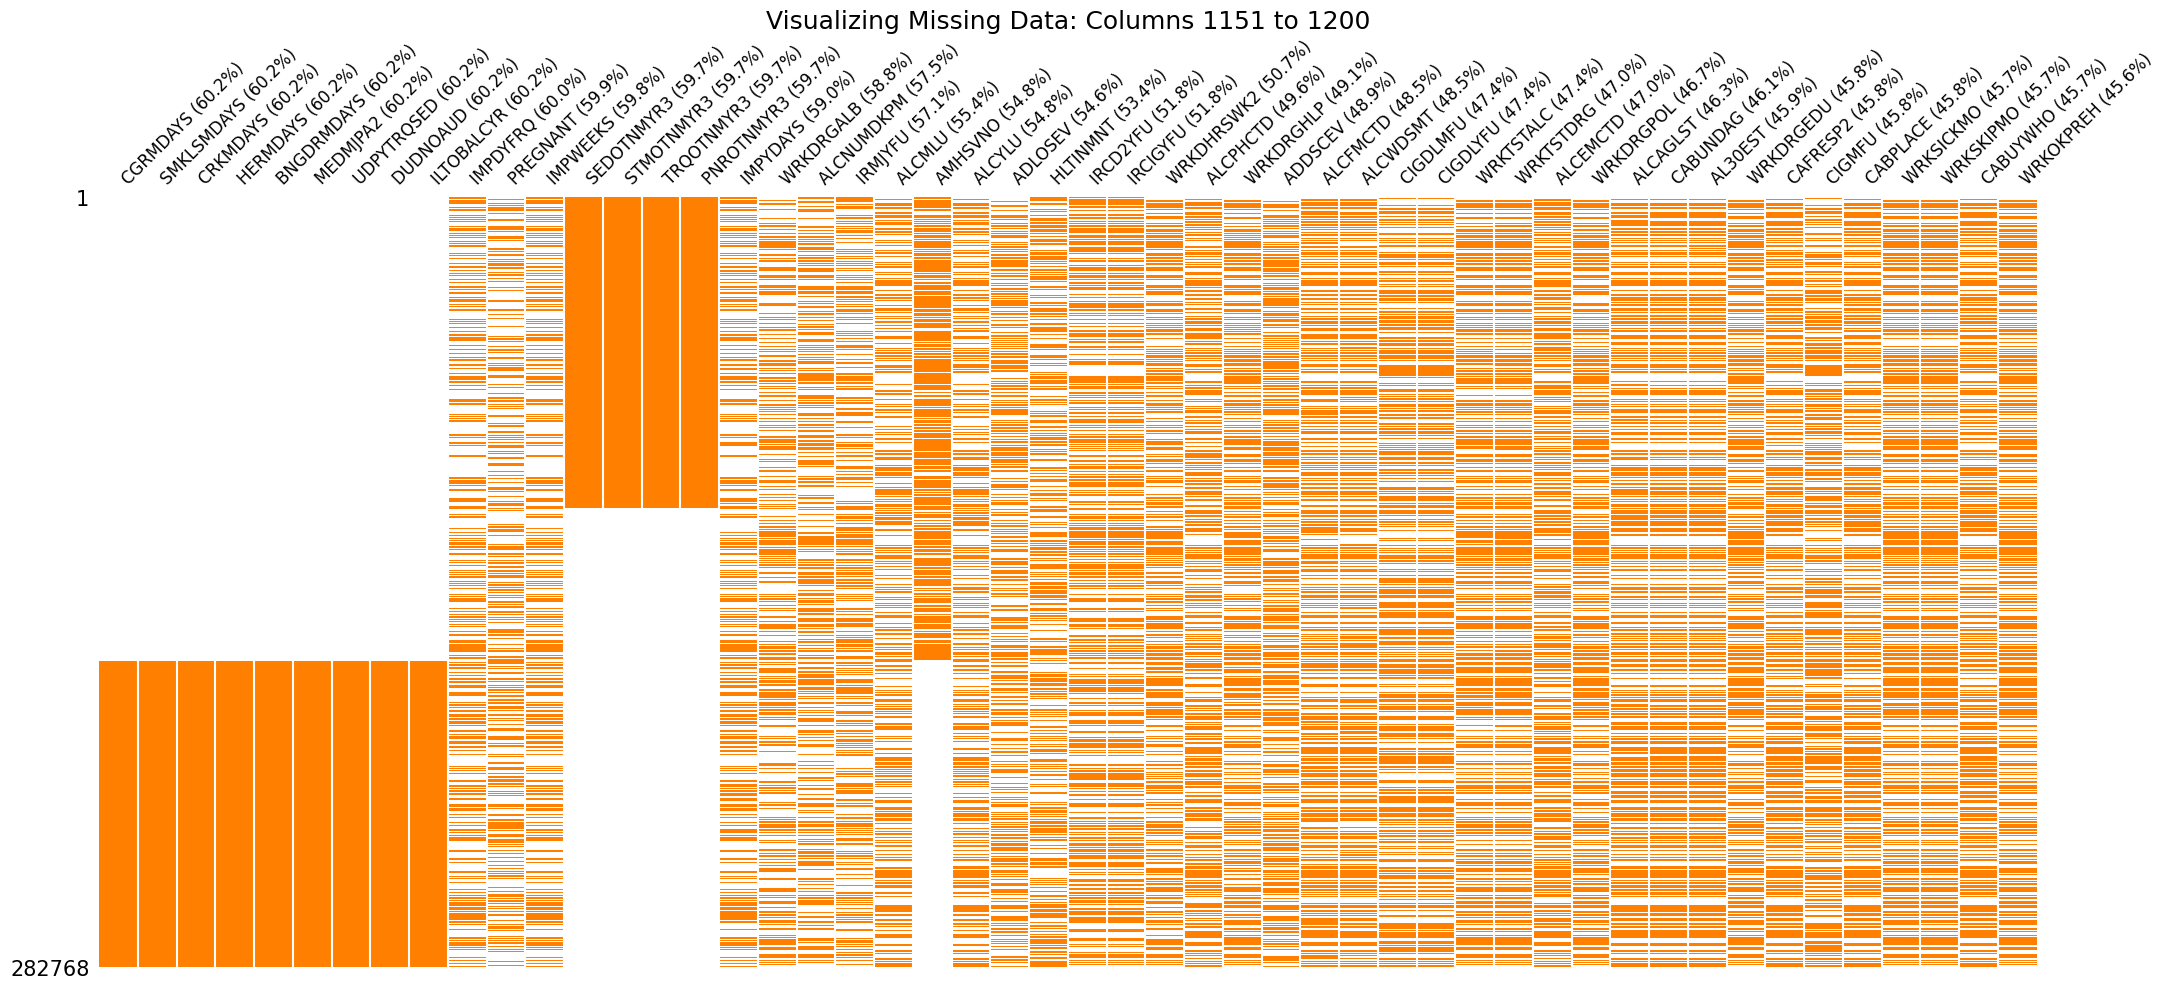

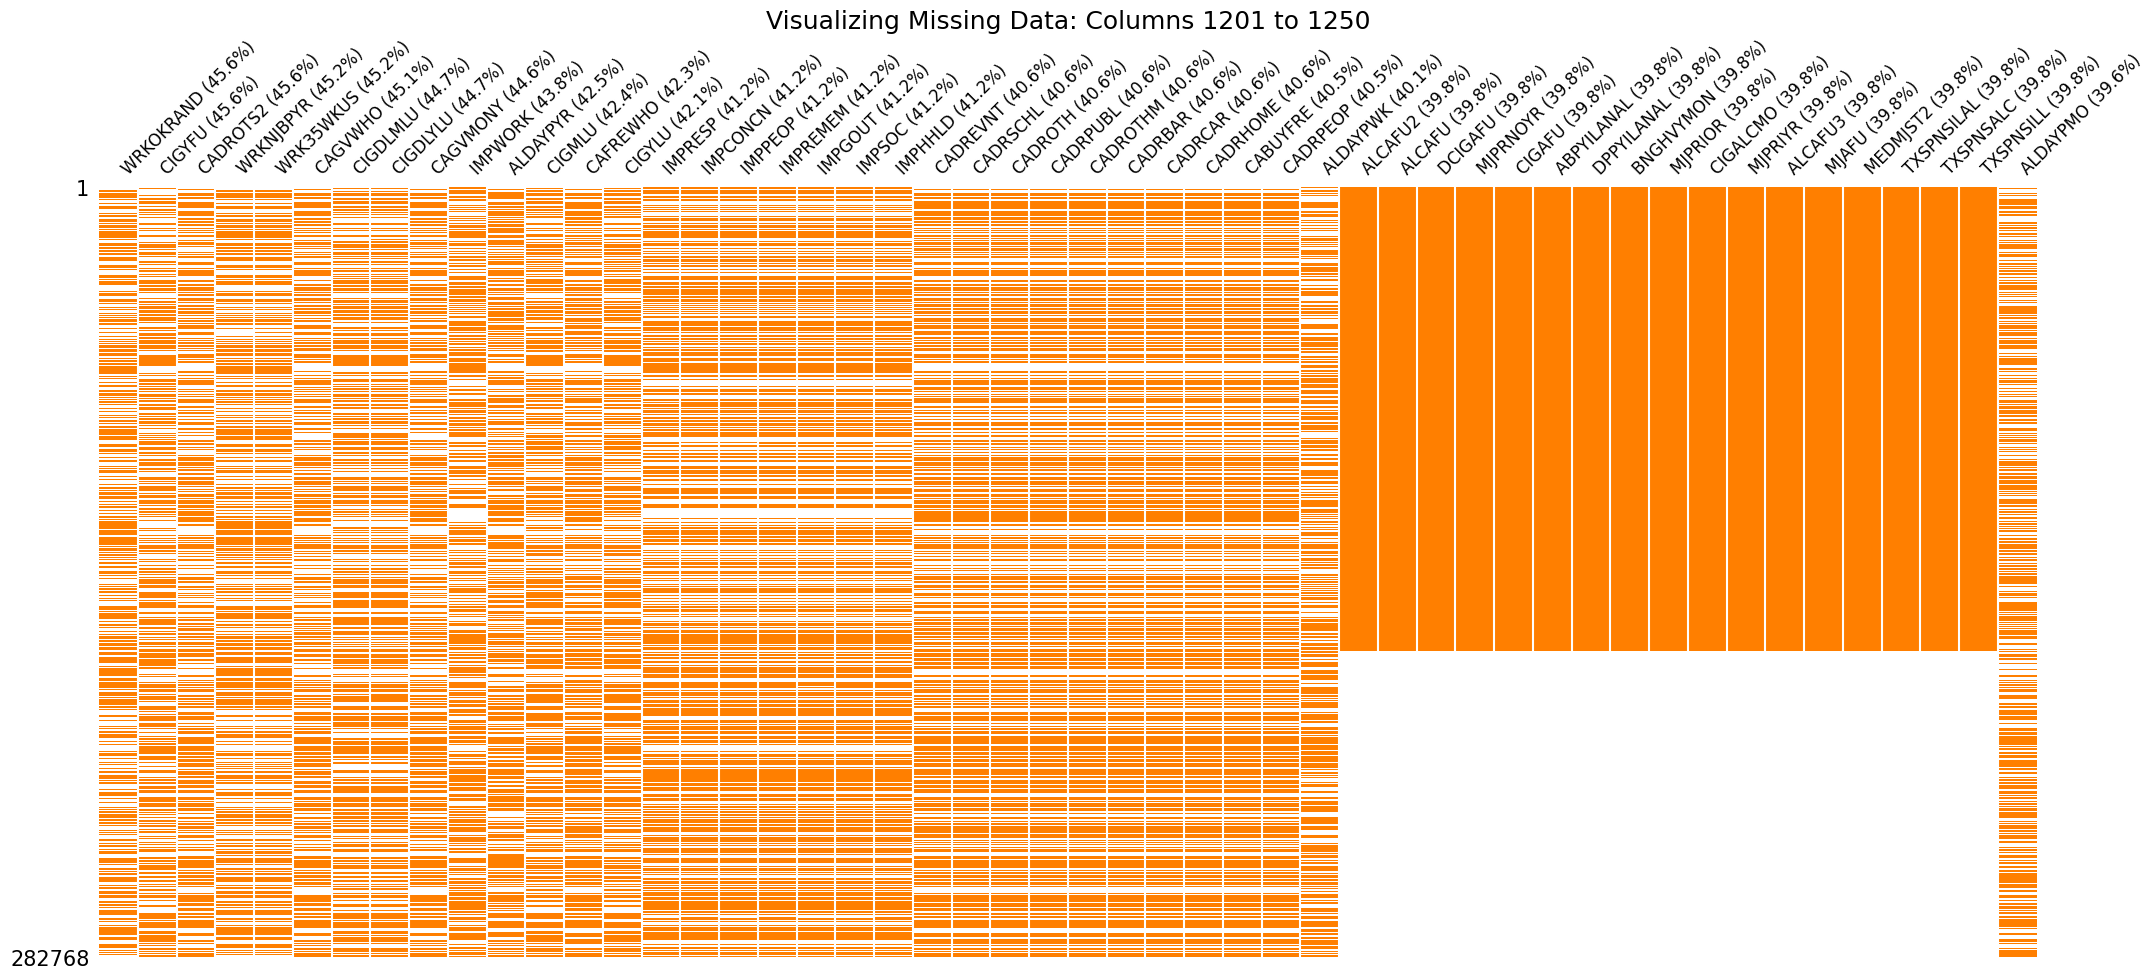

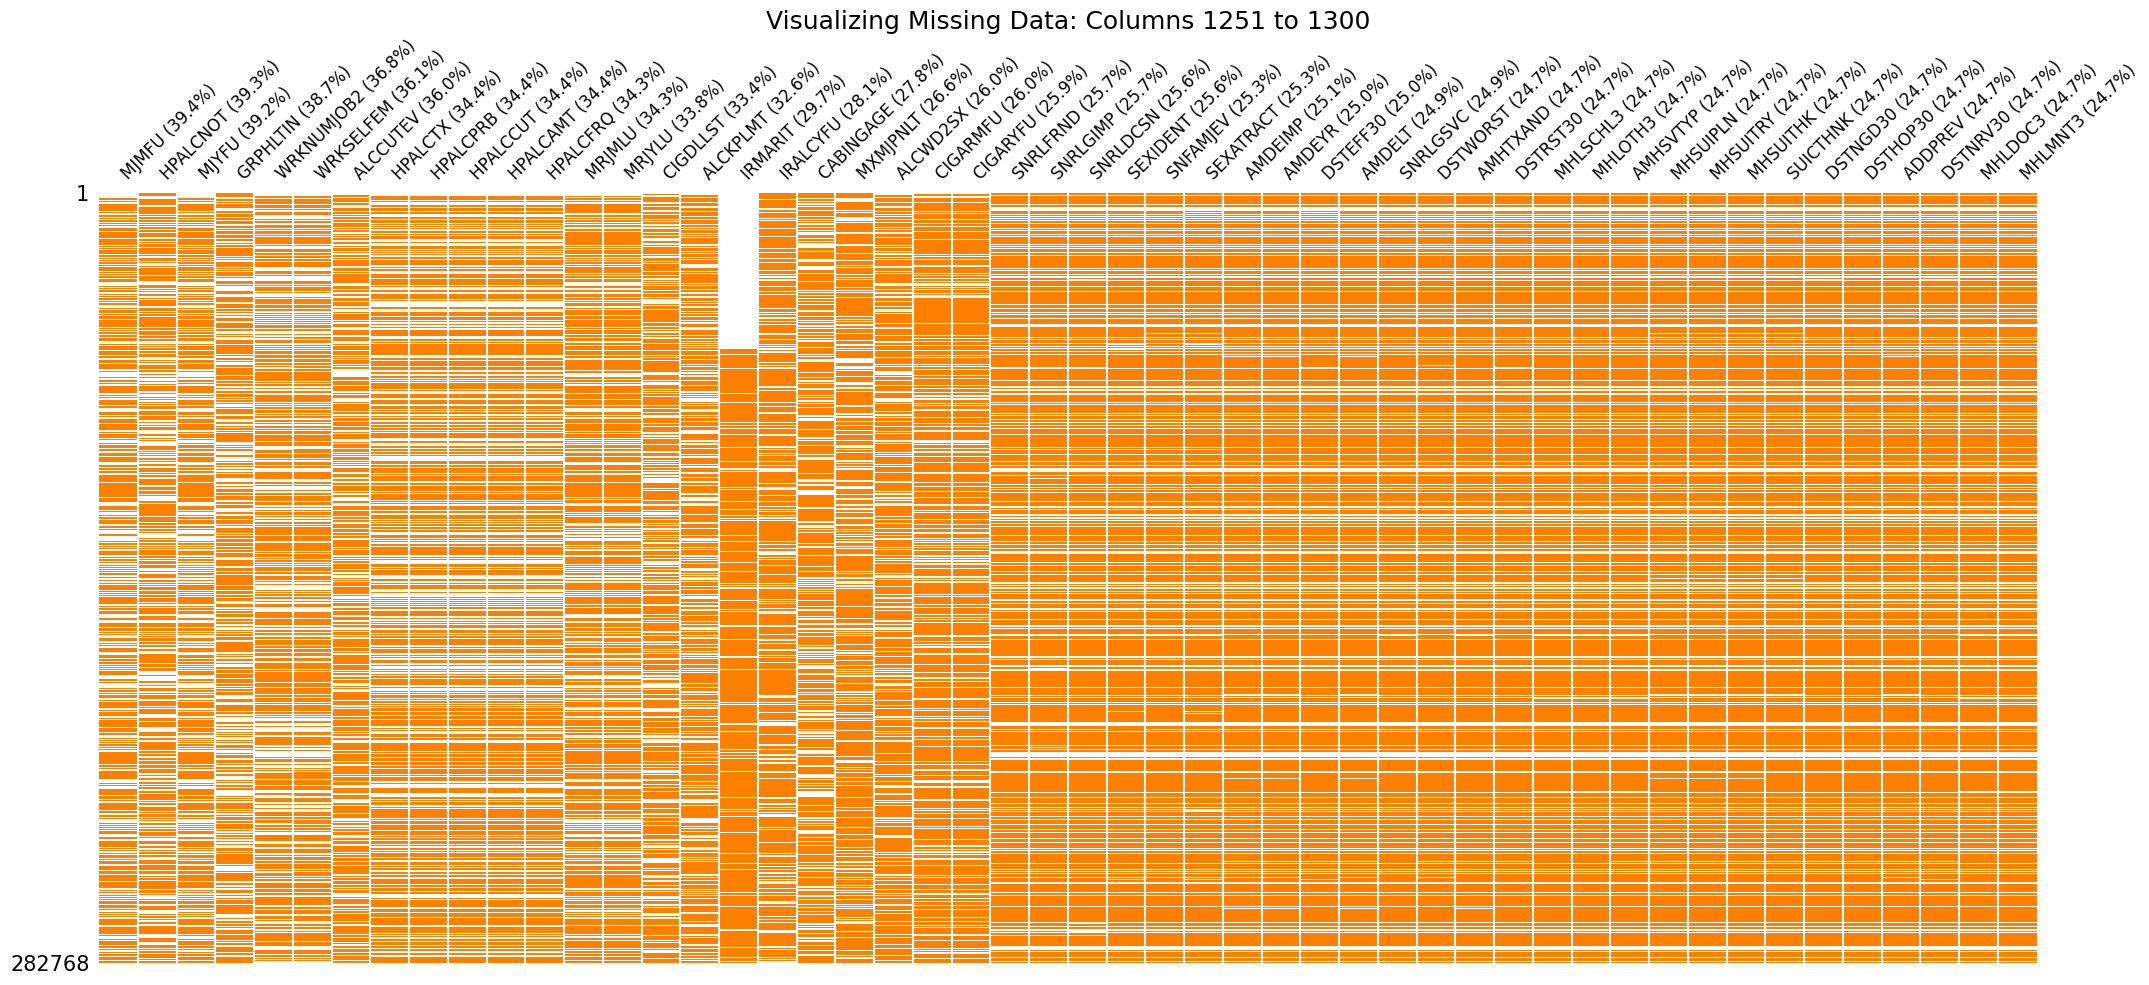

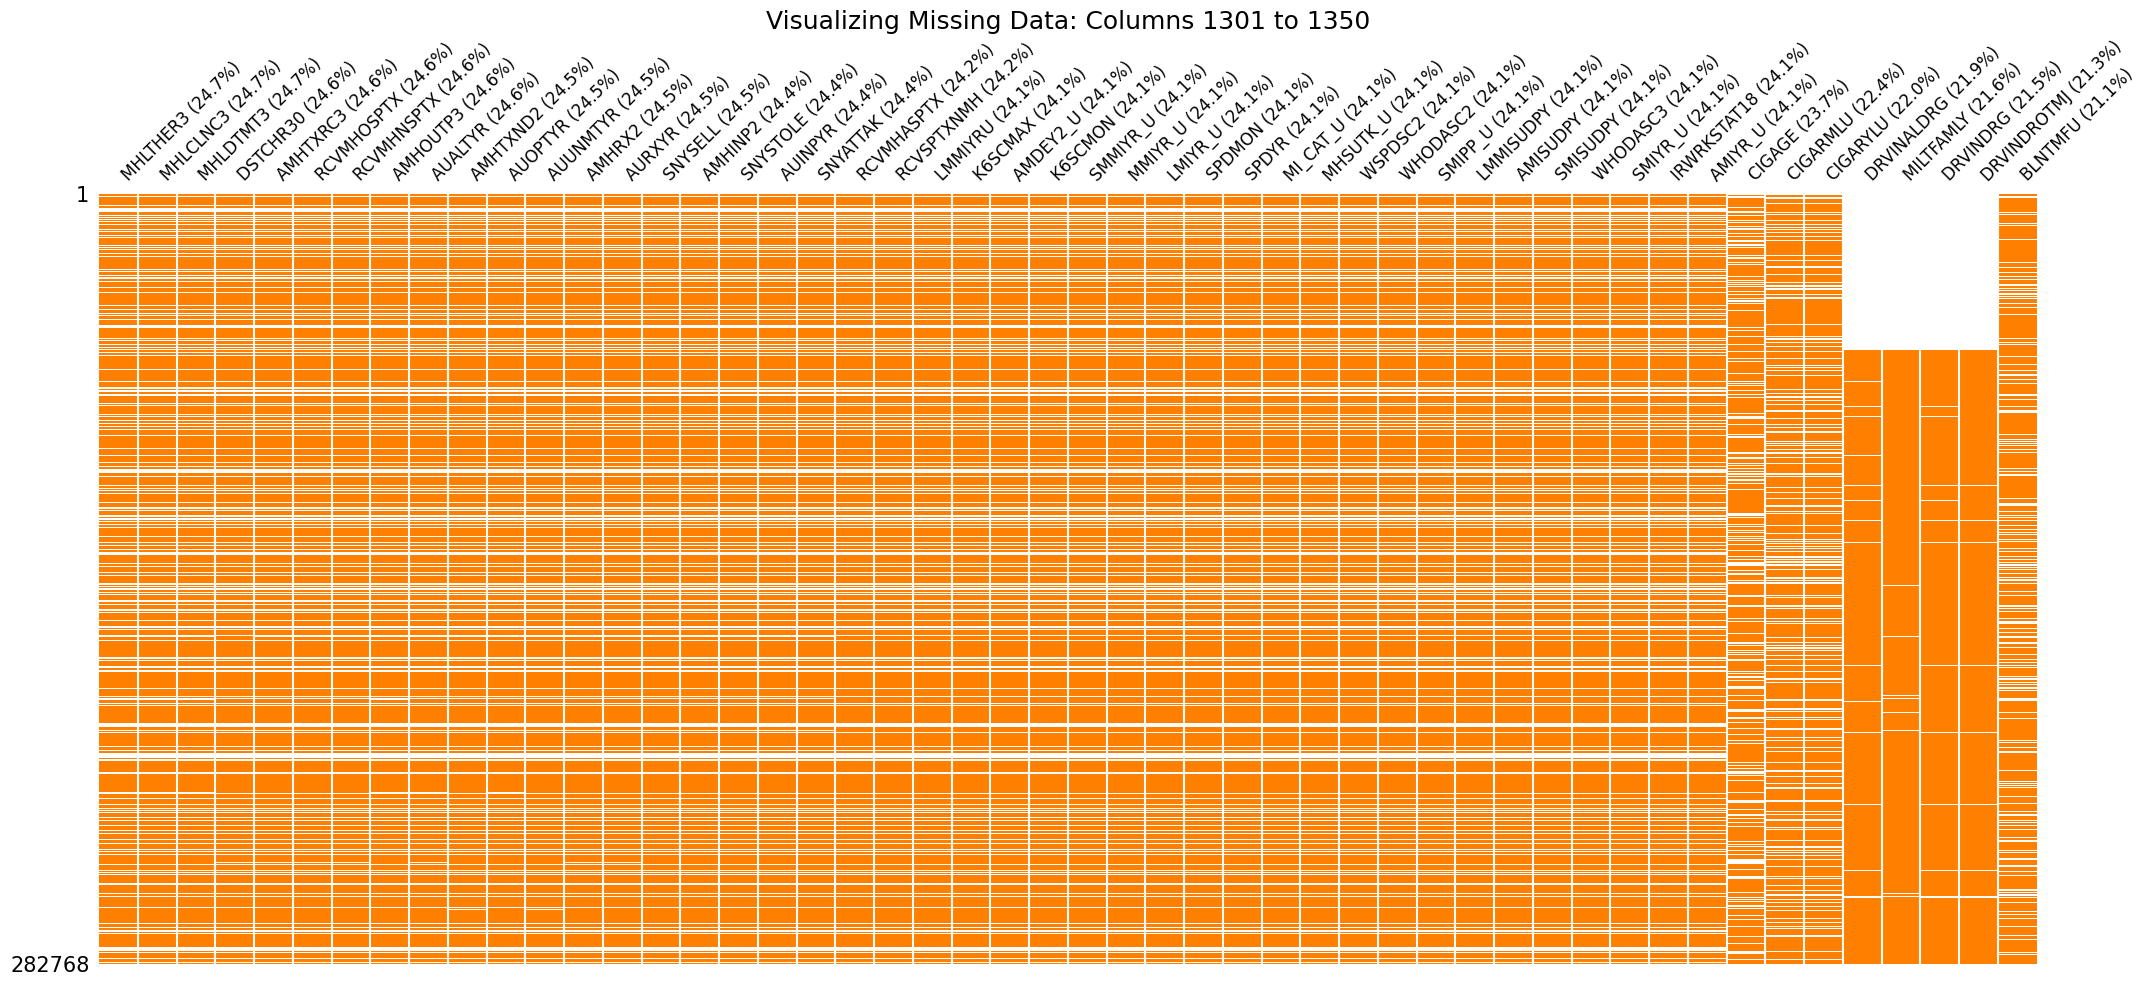

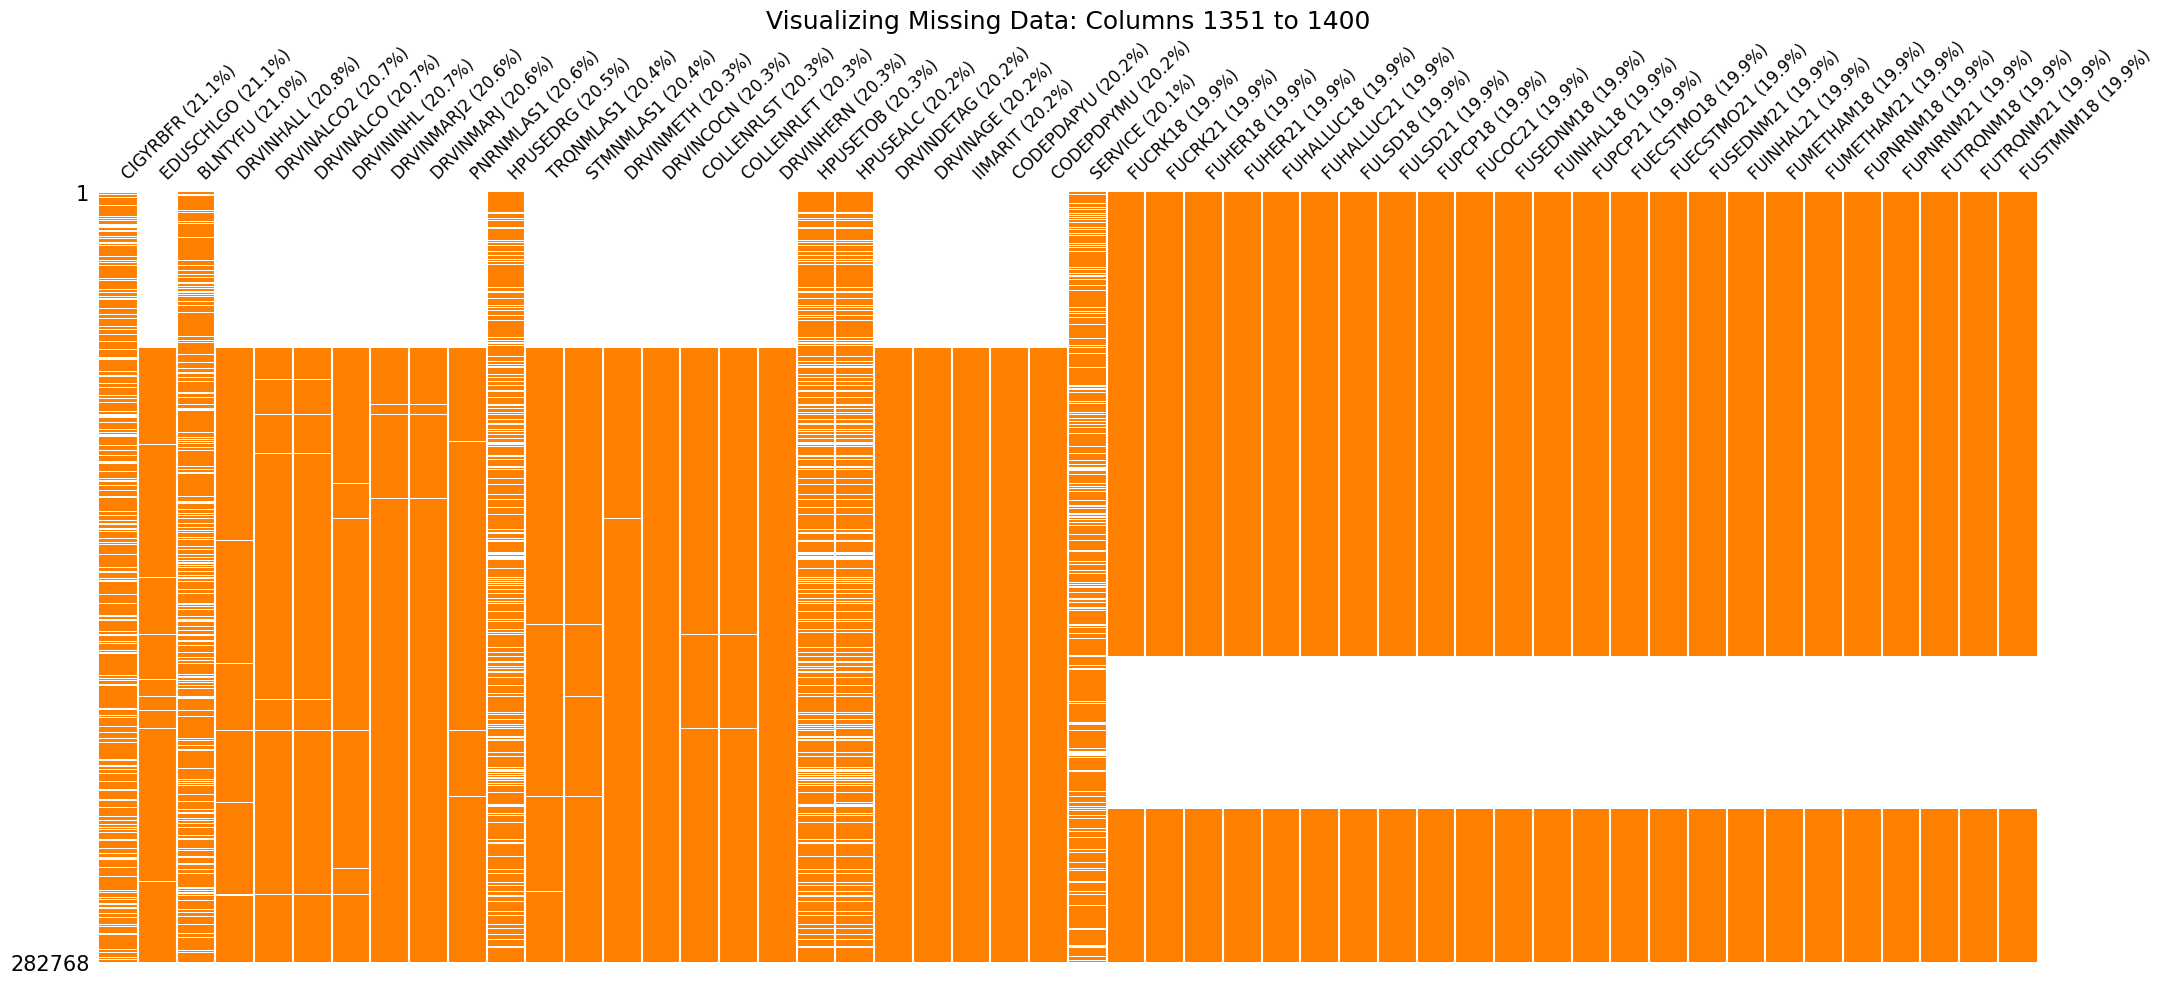

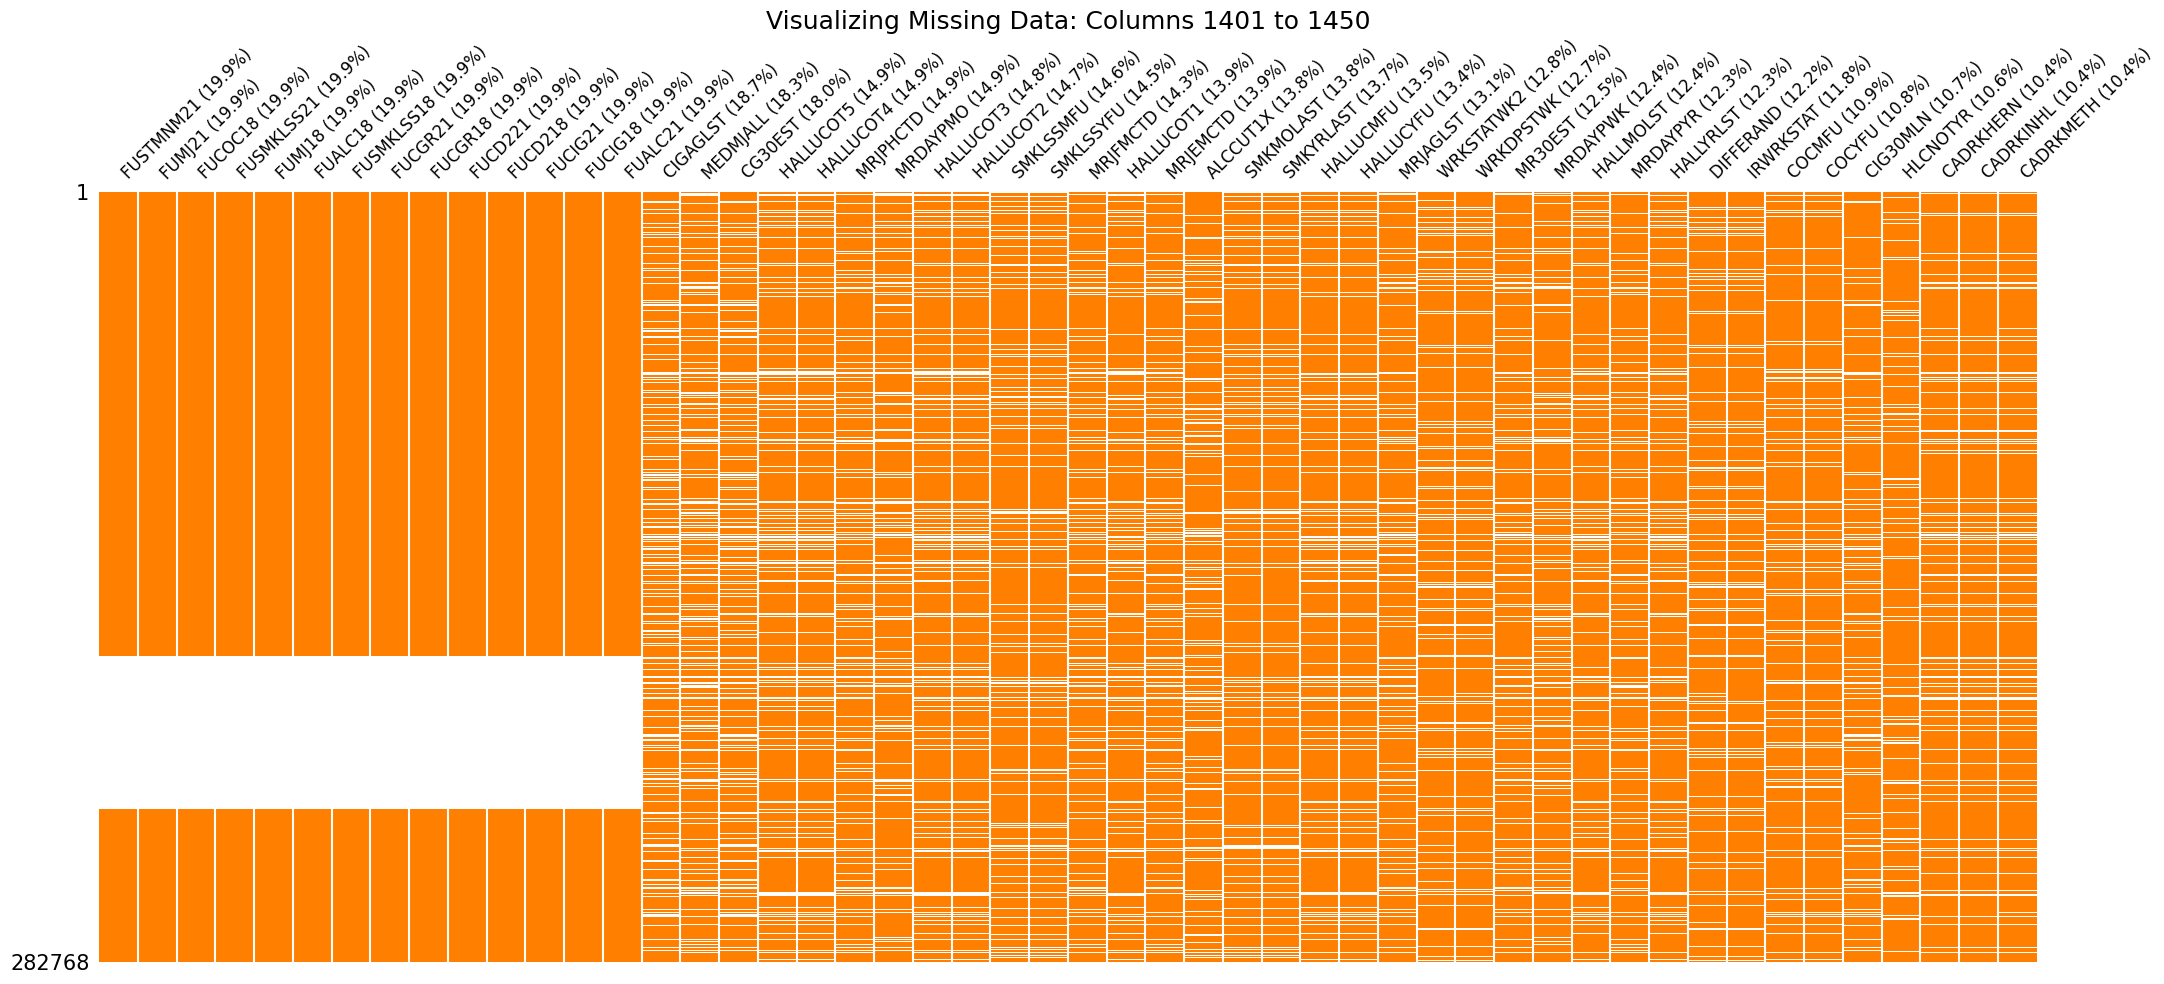

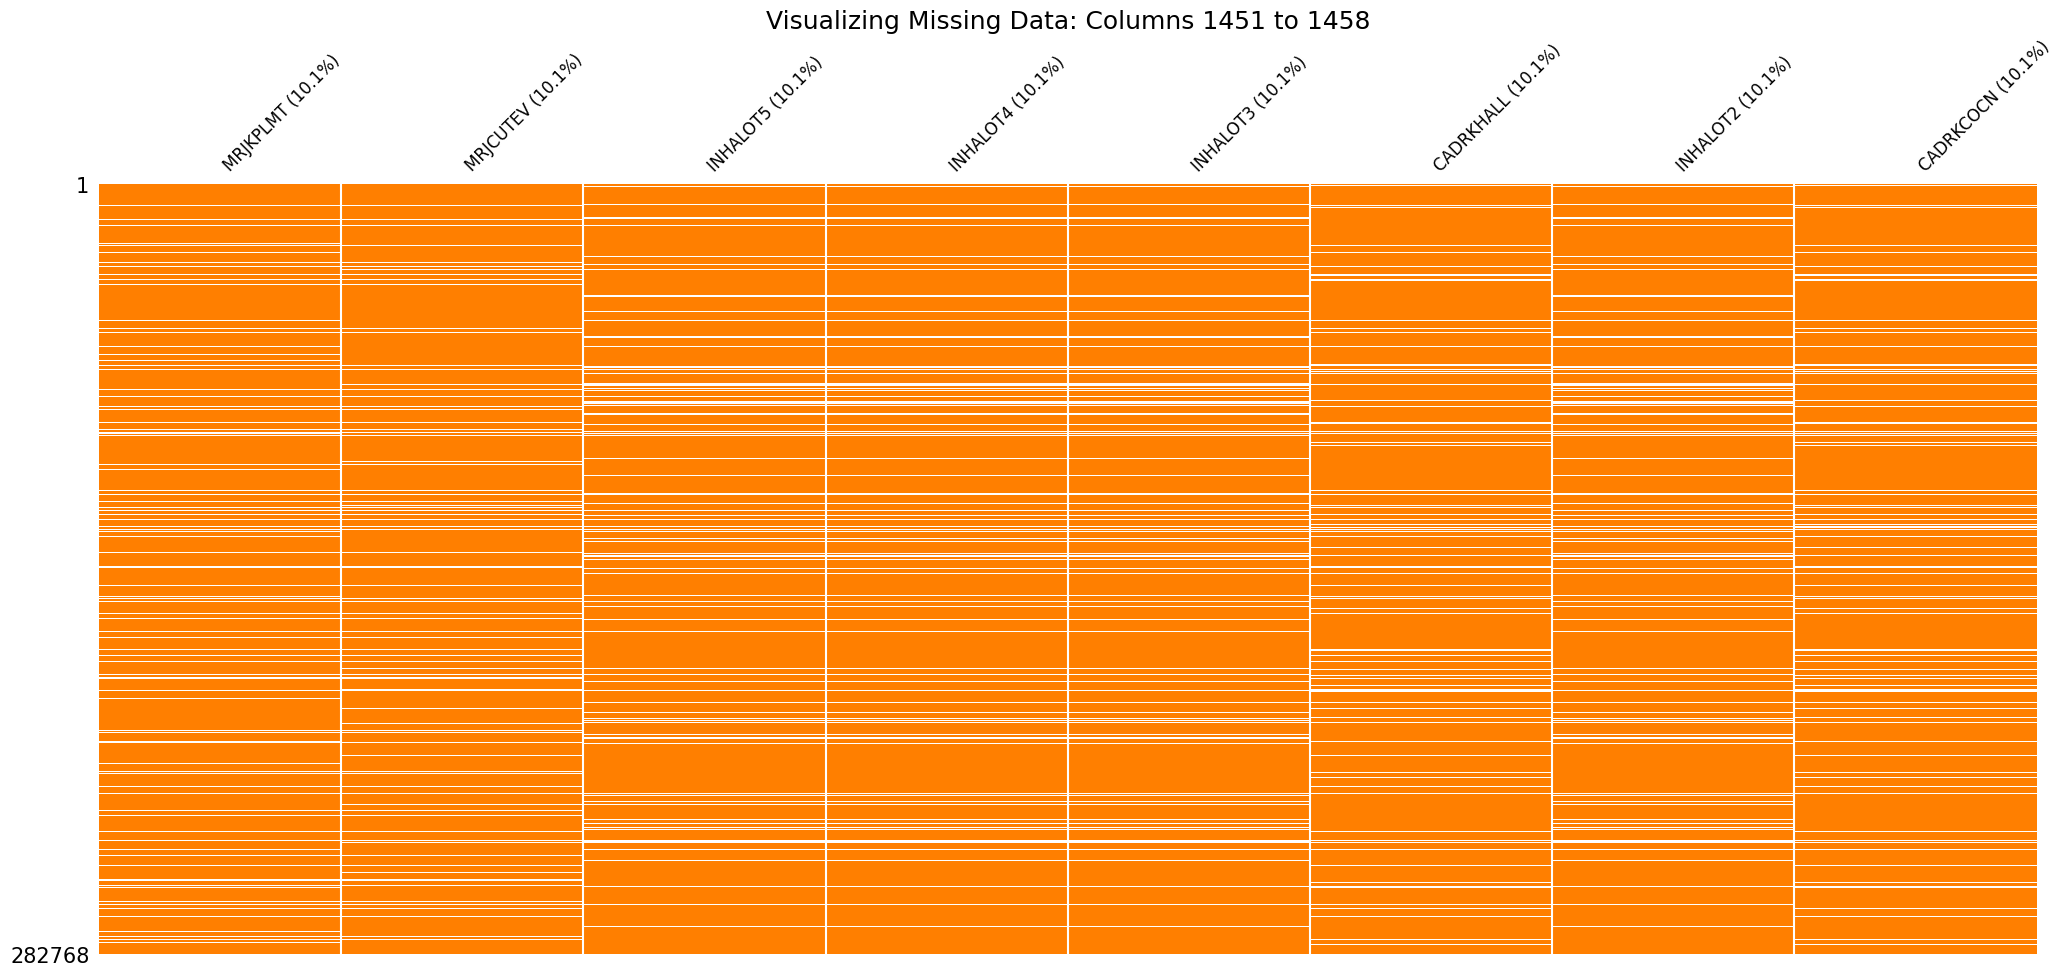

In [63]:


def visualize_missing_columns_in_chunks(df: pd.DataFrame, threshold: float = 20.0, chunk_size: int = 50) -> None:
    """
    Visualizes the missing values for columns that have more than the given percentage of missing data using `msno.matrix`,
    iterating over the columns in chunks, and customizes the color to orange with missing percentages in column names.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    threshold (float): The percentage threshold to filter columns. Default is 20%.
    chunk_size (int): The number of columns to visualize per iteration. Default is 50.
    """
    # Calculate the percentage of missing values for each column
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    
    # Filter columns that have more than the specified percentage of missing values
    columns_with_missing = missing_percentage[missing_percentage > threshold].sort_values(ascending=False)
    
    # Create a dictionary to rename the columns by adding the missing percentage to the name
    renamed_columns = {col: f"{col} ({missing_percentage[col]:.1f}%)" for col in columns_with_missing.index}
    
    # Create a DataFrame copy with renamed columns for those with missing values above the threshold
    df_with_missing_renamed = df[columns_with_missing.index].rename(columns=renamed_columns)
    
    # Determine the number of iterations needed
    num_chunks = math.ceil(len(columns_with_missing) / chunk_size)
    
    # Iterate and visualize columns in chunks
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(columns_with_missing))
        
        # Get the subset of renamed columns for the current chunk
        chunk_columns = list(renamed_columns.values())[start_idx:end_idx]
        
        # Use msno.matrix directly without plt.figure() to suppress the figure message
        msno.matrix(df_with_missing_renamed[chunk_columns], fontsize=12, sparkline=False, color=(1.0, 0.5, 0.0))  # RGB color for orange
        
        # Add a title showing the range of columns being visualized and set a bigger font size
        plt.title(f"Visualizing Missing Data: Columns {start_idx + 1} to {end_idx}", fontsize=18)  # Adjusted title size
        
        # Display the plot
        plt.show()


visualize_missing_columns_in_chunks(df, threshold=10.0, chunk_size=50)


### Observations from `msno.matrix()` Visualization

- **High Missing Values**: 
  - There are **1,458 columns** with more than **10% missing values**.
  
- **Patterns of Missingness**: 
  - We can observe clear patterns of missing data where **certain columns have data present in earlier years but are missing in later years**, and conversely, **some columns are missing in earlier years but have data available in later years**. 
  - This indicates that the missingness is **non-random** and could be related to the **time period** or changes in data collection processes over time.
  
- **Next Steps**:
  - Consider potential imputation strategies, especially for time-based patterns.
  - If necessary, drop columns with high missing percentages or those that do not contribute significantly to the analysis.


## Sharan Raj Sivakumar Hypothesis

### Hypothesis 1: Early drug use, particularly during adolescence, is a risk factor for the development of mental health issues. 
#### Null Hypothesis: There is no relationship between early drug use and the development of mental health issues.
#### Alternative Hypothesis: Early drug use is associated with an increased risk of developing mental health issues.

In [203]:
identity_columns_H1 = ['QUESTID2']
# drug_usage_columns_H1 = ['MJEVER','MJAGE', 'BLNTEVER', 'BLNTAGE','COCEVER', 'COCAGE', 'CRKEVER', 'CRKAGE', 'HEREVER', 'HERAGE', 'HALLUCEVR','HALLUCAGE', 'METHAMEVR', 'METHAMAGE']

drug_usage_columns_H1 = ['MJAGE', 'BLNTAGE','COCAGE',  'CRKAGE',  'HERAGE', 'HALLUCAGE', 'METHAMAGE']


mental_health_columns_H1 = ['YMDELT']

columns_of_interest_H1 = identity_columns_H1 + drug_usage_columns_H1 + mental_health_columns_H1


In [204]:
# Creating a copy of df for Hypothesis 2 analysis
df_H1 = df[columns_of_interest_H1].copy()

In [205]:
# Get unique values for each column
for column in df_H1.columns:
    unique_values = df_H1[column].unique()
    print(f"\nUnique values for {column}:")
    print(unique_values)


Unique values for QUESTID2:
[25095143 13005143 67415143 ... 38044730 43164730 92074730]

Unique values for MJAGE:
[991  15  14  18 985  12  21  24  17  13  22  35  16  20  19  23  25  36
  38 994   7  30  32   9  11  29  10  27  28  26  31  39   8  37  55  40
  45  34  51  50 998  44  76 997  48  42   5  56  52   6   2  47  43   3
  33   4  54  49  58  72  65  46  57  64  69  62  60  75   1  77  41  78
  74  68  53  61  66  71  67  59  80  63  70  81  79  73  82]

Unique values for BLNTAGE:
[991  26  16  21  14  15 994  18  17  35  19  20  12  13  22  40  36  30
  25  10  23  34  45   6  28  11  56   8  29  24  38  42 997  27  54  32
  31  60  47 981 998   9  55  50   7  37   2  49  48  59  43  53   1  46
 985  33   3  44  41  58  39  52  57  65  51   5  62  66   4  61  63  76
  68  73  64  70  69]

Unique values for COCAGE:
[991  16  13  20  15  24  18  34  19  25  22  17  14  21  27  23  26  12
  50  35  30  37  29  36  28  31 994  38  48 997  39  40  33  32  11 985
   2  55  45 998

In [206]:
# Clean the data
df_H1 = df_H1.drop_duplicates()  # Remove duplicates

In [207]:
df_H1[drug_usage_columns_H1+mental_health_columns_H1].describe()

MJAGE   BLNTAGE    COCAGE    CRKAGE    HERAGE  HALLUCAGE  METHAMAGE  \
count 281835.00 281835.00 281835.00 281835.00 281835.00  281835.00  281835.00   
mean     575.25    763.95    877.24    965.19    974.43     851.72     947.53   
std      481.69    411.66    312.15    155.91    125.60     340.62     200.71   
min        1.00      1.00      1.00      1.00      1.00       1.00       1.00   
25%       17.00    991.00    991.00    991.00    991.00     991.00     991.00   
50%      991.00    991.00    991.00    991.00    991.00     991.00     991.00   
75%      991.00    991.00    991.00    991.00    991.00     991.00     991.00   
max      998.00    998.00    998.00    998.00    998.00     998.00     998.00   

        YMDELT  
count 66390.00  
mean      1.80  
std       0.40  
min       1.00  
25%       2.00  
50%       2.00  
75%       2.00  
max       2.00

In [208]:
# Define a dictionary for replacements based on the code conventions
code_replacements = {
    93: np.nan,
    993: np.nan,
    9993: np.nan,
    94: np.nan,  # Don't Know
    994: np.nan,
    9994: np.nan,
    97: np.nan,  # Refused
    997: np.nan,
    9997: np.nan,
    98: np.nan,  # Blank
    998: np.nan,
    9998: np.nan,
    99: np.nan,  # Legitimate Skip
    999: np.nan,
    9999: np.nan,
    89: np.nan,  
    989: np.nan,
    9989: np.nan,
    85: np.nan, # Bad data
    985: np.nan,
    9985: np.nan
}

# Apply the replacements to the DataFrame
df_H1.replace(code_replacements, inplace=True)

# Drop rows with missing values
df_H1.dropna(inplace=True)

In [209]:
# Convert all to integer
df_H1 = df_H1.astype(int)

In [210]:
# Get unique values for each column
for column in df_H1.columns:
    unique_values = df_H1[column].unique()
    print(f"\nUnique values for {column}:")
    print(unique_values)


Unique values for QUESTID2:
[25095143 70925143 63765143 ... 38044730 43164730 92074730]

Unique values for MJAGE:
[991  14  12  15  17  16  13  11   9  10   8   5   7   2   6   1   3   4]

Unique values for BLNTAGE:
[991  16  14  15  17  12  13  10   8   6 981   7  11   9   1   2   5   3
   4]

Unique values for COCAGE:
[991  15  14  16  17  12  13  10   8   7   9  11   1   6]

Unique values for CRKAGE:
[991  14  15  13  12   8  17  16  11   6]

Unique values for HERAGE:
[991  15  14  13  12   9  16  17  11   5  10]

Unique values for HALLUCAGE:
[991  14  15  17  12  13  16   2   1  10  11   9   8   6   7   4   5]

Unique values for METHAMAGE:
[991  14  15  12  16  17  10  11   9  13   1   8   5   2   6]

Unique values for YMDELT:
[1 2]


In [211]:
# Condition for never used drugs
never_used_condition = (df_H1 == 991) | (df_H1 == 981)

# DataFrame for no drug use
no_drug_use_df = df_H1[never_used_condition[drug_usage_columns_H1].all(axis=1)]
no_drug_use_df["Drug_Use"] = 0

# DataFrame for any drug use
any_drug_use_df = df_H1[~never_used_condition[drug_usage_columns_H1].all(axis=1)]
any_drug_use_df["Drug_Use"] = 1

df_H1 = pd.concat([no_drug_use_df,any_drug_use_df])

# Add a binary column for drug use
# df_H1['Drug_Use'] = ~(df_H1 == 991).all(axis=1) & ~(df_H1 == 981).all(axis=1)


print(f"No Drug Use DataFrame Shape:{df_H1[df_H1['Drug_Use']==0].shape}")

print(f"Any Drug Use DataFrame Shape:{df_H1[df_H1['Drug_Use']==1].shape}")

No Drug Use DataFrame Shape:(53755, 10)
Any Drug Use DataFrame Shape:(11040, 10)


In [212]:
# Hypothesis Test
t_stat, p_value = stats.ttest_ind(no_drug_use_df['YMDELT'].dropna(), any_drug_use_df['YMDELT'].dropna())

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 43.34074470538926
P-value: 0.0


### Interpretation of Results:

- **T-statistic**: 43.341  
  A **T-statistic** of 43.341 is very large. This indicates that the difference between early drug users and non-drug users (in terms of developing mental health issues) is much greater than what would be expected under the null hypothesis. In other words, this large T-value suggests a strong association between early drug use and the development of mental health issues.

- **P-value**: 0.0  
  A **P-value** of 0.0 (or something extremely close to 0) indicates that the likelihood of observing this data if the null hypothesis were true (i.e., if there really is no association between early drug use and mental health issues) is virtually **zero**.

---

### Conclusion:
- Given the very high T-statistic and the P-value of 0.0, you would **reject the null hypothesis** with great confidence.
- There is very strong evidence to suggest that early drug use, particularly during adolescence, is a significant risk factor for the development of mental health issues.
- The result implies that the observed relationship is not due to random chance but is likely a true effect in the population.

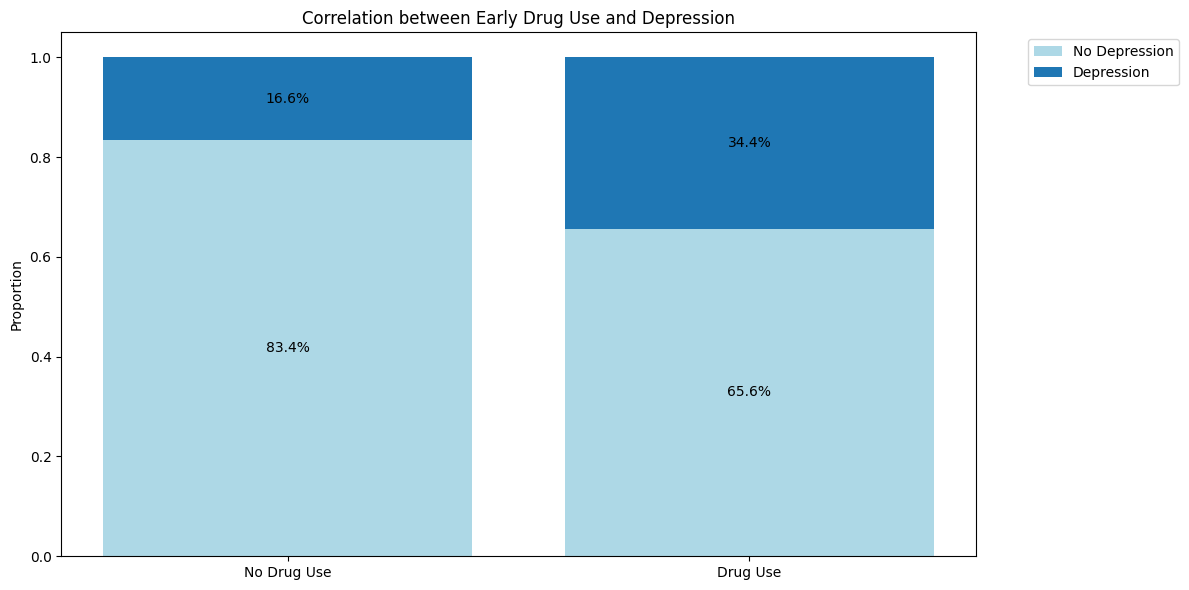

In [213]:
# Calculate the proportions
drug_use_0 = df_H1[df_H1['Drug_Use'] == 0]['YMDELT'].value_counts(normalize=True)
drug_use_1 = df_H1[df_H1['Drug_Use'] == 1]['YMDELT'].value_counts(normalize=True)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

labels = ['No Drug Use', 'Drug Use']
no_depression = [drug_use_0.get(2, 0), drug_use_1.get(2, 0)]
depression = [drug_use_0.get(1, 0), drug_use_1.get(1, 0)]

ax.bar(labels, no_depression, label='No Depression', color='lightblue')
ax.bar(labels, depression, bottom=no_depression, label='Depression')

ax.set_ylabel('Proportion')
ax.set_title('Correlation between Early Drug Use and Depression')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels on the bars
for i, (no_dep, dep) in enumerate(zip(no_depression, depression)):
    ax.text(i, no_dep/2, f'{no_dep:.1%}', ha='center', va='center')
    ax.text(i, no_dep + dep/2, f'{dep:.1%}', ha='center', va='center')

plt.tight_layout()
plt.show()

### Key Observations:

1. **No Drug Use Group**:
   - **83.4%** of individuals who did not use drugs early are not depressed.
   - **16.6%** of individuals in the "No Drug Use" group suffer from depression.

2. **Drug Use Group**:
   - **65.6%** of individuals who used drugs early are not depressed.
   - **34.4%** of individuals in the "Drug Use" group suffer from depression.

---

### Interpretation:
- **Higher Depression in Drug Users**: The proportion of individuals with depression is notably higher in the "Drug Use" group (**34.4%**) compared to the "No Drug Use" group (**16.6%**).
- **Lower Depression in Non-Drug Users**: Conversely, individuals who did not engage in early drug use show a much higher rate of being non-depressed (**83.4%**) compared to the "Drug Use" group (**65.6%**).

---

### Conclusion:
The chart visually supports the hypothesis that early drug use is associated with a higher likelihood of developing depression. There is a clear difference between the two groups, with a higher proportion of depression among those who used drugs early in life. This suggests that early drug use could be a risk factor for depression, as the relationship is clearly visible in the data.

### Hypothesis 2: Individuals who are married or widowed are less likely to experience suicidal thoughts compared to individuals who are single. 
#### Null Hypothesis: There is no relationship between being marital status and experiencing suicidal thoughts.
#### Alternative Hypothesis: Married or widowed individuals have lesser chance of experiencing suicidal thoughts 

In [230]:
identity_columns_H2 = ['QUESTID2']

independent_columns_H2 = ['IRMARIT']

dependent_columns_H2 = ['SUICTHNK']

columns_of_interest_H2 = identity_columns_H2 + independent_columns_H2 + dependent_columns_H2


In [231]:
# Creating a copy of df for Hypothesis 3 analysis
df_H2 = df[columns_of_interest_H2].copy()

In [232]:
# Get unique values for each column
for column in df_H2.columns:
    if column not in identity_columns_H2:
        unique_values = df_H2[column].unique()
        print(f"\nUnique values for {column}:")
        print(unique_values)


Unique values for IRMARIT:
[nan  1.  4.  2. 99.  3.]

Unique values for SUICTHNK:
[99  2 94 97  1 85 98 89]


In [233]:
# Clean the data
df_H2 = df_H2.drop_duplicates()  # Remove duplicates

In [234]:
df_H2[independent_columns_H2+dependent_columns_H2].describe()

IRMARIT  SUICTHNK
count 224857.00 282003.00
mean      14.22     25.92
std       31.14     41.85
min        1.00      1.00
25%        1.00      2.00
50%        4.00      2.00
75%        4.00      2.00
max       99.00     99.00

In [235]:
# Define a dictionary for replacements based on the code conventions for IRMARIT
code_replacements = {1:"Married", 2:"Widowed", 3:np.nan, 4:"Single", 99: np.nan}


# Apply the replacements to the DataFrame
df_H2["IRMARIT"].replace(code_replacements, inplace=True)


# Define a dictionary for replacements based on the code conventions for SUICTHNK
code_replacements = {85:np.nan, 89:np.nan, 94:np.nan, 97:np.nan, 98:np.nan, 99: np.nan}

# Apply the replacements to the DataFrame
df_H2["SUICTHNK"].replace(code_replacements, inplace=True)

# Drop rows with missing values
df_H2.dropna(inplace=True)

In [236]:
# Convert all to integer
df_H2["SUICTHNK"] = df_H2["SUICTHNK"].astype(int)

In [237]:
# Get unique values for each column
for column in df_H2.columns:
    if column not in identity_columns_H2:
        unique_values = df_H2[column].unique()
        print(f"\nUnique values for {column}:")
        print(unique_values)


Unique values for IRMARIT:
['Married' 'Single' 'Widowed']

Unique values for SUICTHNK:
[2 1]


In [238]:
single_df_H2 = df_H2[df_H2["IRMARIT"]=="Single"]
not_single_df_H2 = df_H2[df_H2["IRMARIT"]!="Single"]


In [239]:
# Hypothesis Test
t_stat, p_value = stats.ttest_ind(not_single_df_H2['SUICTHNK'], single_df_H2["SUICTHNK"])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 50.2948528555206
P-value: 0.0


### Results:
- **T-statistic**: 50.295  
  A **T-statistic** of 50.295 is extremely high, indicating a significant difference between the two groups regarding suicidal thoughts. This suggests that the observed data deviate greatly from what would be expected under the null hypothesis.

- **P-value**: 0.0  
  A **P-value** of 0.0 (or very close to it) indicates that the probability of observing such extreme results, assuming the null hypothesis is true, is virtually zero. This strongly suggests that the null hypothesis can be rejected.

---

### Conclusion:
Given the very high T-statistic and the P-value of 0.0, we can confidently **reject the null hypothesis**. There is compelling evidence to support the alternative hypothesis that individuals who are single are significantly more likely to experience suicidal thoughts compared to those who are married or widowed. This result highlights the potential individuals enjoy a sense of companionship(present or former) contributes positively to their happiness.

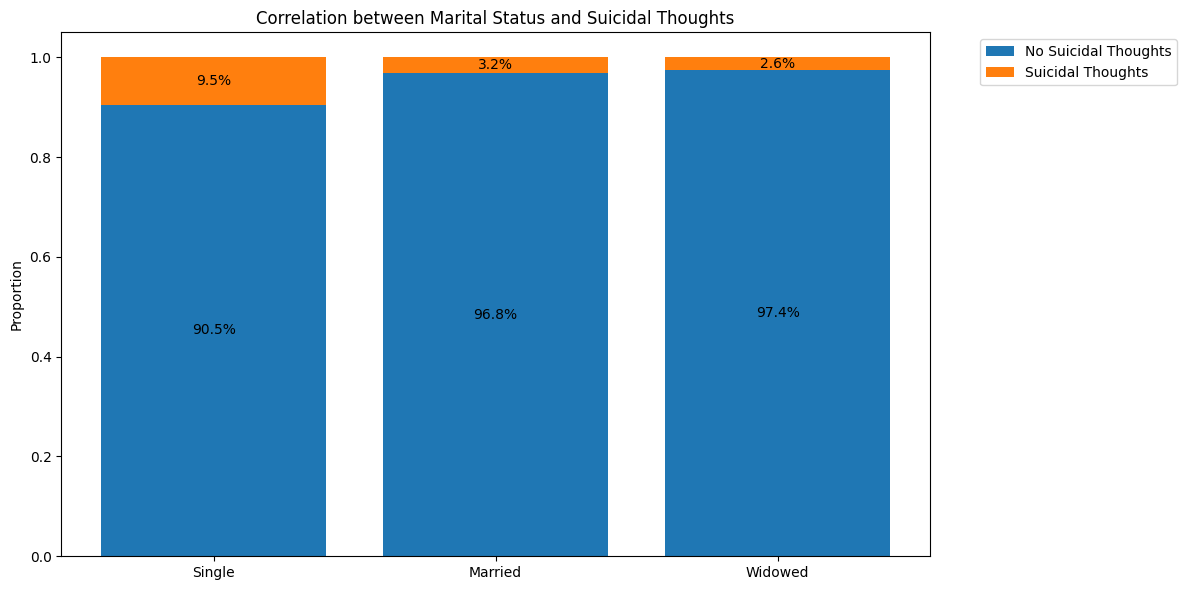

In [240]:
# Calculate the proportions for each marital status
marital_status_0 = df_H2[df_H2['IRMARIT'] == 'Single']['SUICTHNK'].value_counts(normalize=True)
marital_status_1 = df_H2[df_H2['IRMARIT'] == 'Married']['SUICTHNK'].value_counts(normalize=True)
marital_status_2 = df_H2[df_H2['IRMARIT'] == 'Widowed']['SUICTHNK'].value_counts(normalize=True)


# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

labels = ['Single', 'Married', 'Widowed']
no_suicidal_thoughts = [
    marital_status_0.get(2, 0),  # No for Single
    marital_status_1.get(2, 0),  # No for Marriage
    marital_status_2.get(2, 0),  # No for Widowed
]
suicidal_thoughts = [
    marital_status_0.get(1, 0),  # Yes for Single
    marital_status_1.get(1, 0),  # Yes for Marriage
    marital_status_2.get(1, 0),  # Yes for Widowed
]

ax.bar(labels, no_suicidal_thoughts, label='No Suicidal Thoughts')
ax.bar(labels, suicidal_thoughts, bottom=no_suicidal_thoughts, label='Suicidal Thoughts')

ax.set_ylabel('Proportion')
ax.set_title('Correlation between Marital Status and Suicidal Thoughts')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels on the bars
for i, (no_suicidal, suicidal) in enumerate(zip(no_suicidal_thoughts, suicidal_thoughts)):
    ax.text(i, no_suicidal / 2, f'{no_suicidal:.1%}', ha='center', va='center')
    ax.text(i, no_suicidal + suicidal / 2, f'{suicidal:.1%}', ha='center', va='center')

plt.tight_layout()
plt.show()


### Key Observations:

1. **Single Individuals**:
   - **90.5%** of single individuals donot experience having suicidal thoughts.
   - **9.5%** of single individuals experience suicidal thoughts.

2. **Married Individuals**:
   - **96.8%** of married individuals donot experience having suicidal thoughts.
   - **3.2%** of married individuals experience suicidal thoughts.

3. **Widowed Individuals**:
   - **97.4%** of widowed individuals donot experience having suicidal thoughts.
   - **2.6%** of widowed individuals experience suicidal thoughts.

---

### Interpretation:
- **Higher Suicidal Thoughts in Single Individuals**: The proportion of individuals reporting suicidal thoughts is significantly higher in singles compared to married and widowed individual.
---

### Conclusion:
The chart visually supports the hypothesis that marital status is associated with the likelihood of experiencing suicidal thoughts. The data reveals a clear trend, with single individuals showing a higher proportion of suicidal thoughts compared to their married and widowed counterparts. Though Singles do experience higher suicidal thoughts we need to consider other socio-economic factors to further classify since the difference in percentages is less than 7%
